When there is a single value at each time step, the term univariate is used to describe them. Time series that have multiple values at each time step. As you might expect, they're called Multivariate/Panel Time Series. Multivariate Time Series charts can be useful ways of understanding the impact of related data.

In some cases, you might also want to project back into the past to see how we got to where we are now. This process is called imputation. Or you might simply want to fill in holes in your data for what data doesn't already exist.

Time series you'll encounter in real life probably have a bit of each of these features: trend (captures specific direction of time series despite seasonal flactuations.), seasonality (captures events that occur with speccific frequency), autocorrelation (correlates with a delayed copy of itself often called a lag), and noise (or residuals which are fluctuations left behind once trends and seasonality are removed). Models will perform better if we can first remove known sources of variation.

 non-stationary time series. To predict on this we could just train for limited period of time. 

 If time series is stationary, meaning its behavior does not change over time, then great. The more data you have the better. But if it's not stationary then the optimal time window that you should use for training a ML model will vary. 

Time series is a sequence of data points that are organized in time order. That sequence will capture data at equally spaced points in time, and data collected irregularly is not considered times series.


 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
#%matplotlib widget

2023-11-01 16:09:38.196054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      label (list of strings)- tag for the line
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Plot the time series data
    plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    if label:
      plt.legend(fontsize=14, labels=label)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Trend

The *trend* describes the general tendency of the values to go up or down as time progresses. Given a certain time period, you can see if the graph is following an upward/positive trend, downward/negative trend, or just flat. For instance, the housing prices in a good location can see a general increase in valuation as time passes. 

The simplest example to visualize is data that follows a straight line. You will use the function below to generate that. The `slope` argument will determine what the trend is. If you're coming from a mathematics background, you might recognize this as the [slope-intercept form](https://en.wikipedia.org/wiki/Linear_equation#Slope%E2%80%93intercept_form_or_Gradient-intercept_form) with the y-intercept being `0`.

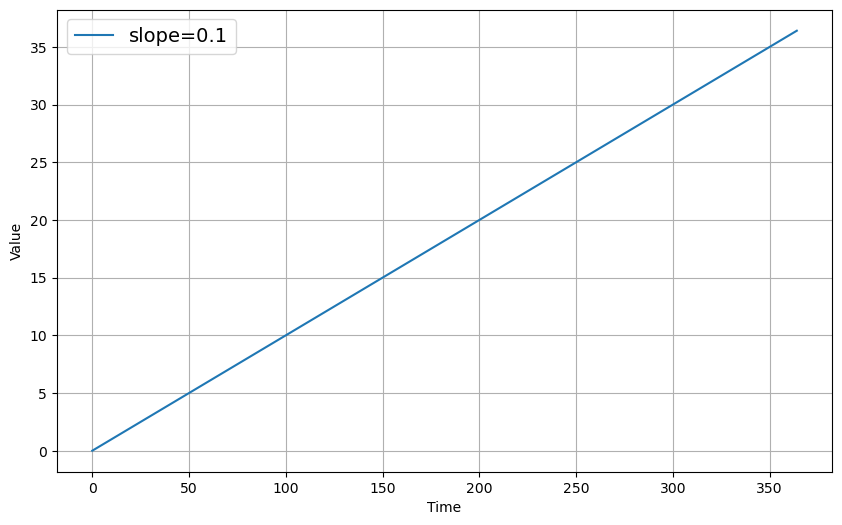

In [3]:
def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


# Generate time steps. Assume 1 per day for one year (365 days)
time = np.arange(365)

# Define the slope (You can revise this)
slope = 0.1

# Generate measurements with the defined slope
series = trend(time, slope)

# Plot the results
plot_series(time, series, label=[f'slope={slope}'])

## Seasonality

Another attribute you may want to look for is seasonality. This refers to a recurring pattern at regular time intervals. For instance, the hourly temperature might oscillate similarly for 10 consecutive days and you can use that to predict the behavior on the next day. 

You can use the functions below to generate a time series with a seasonal pattern:

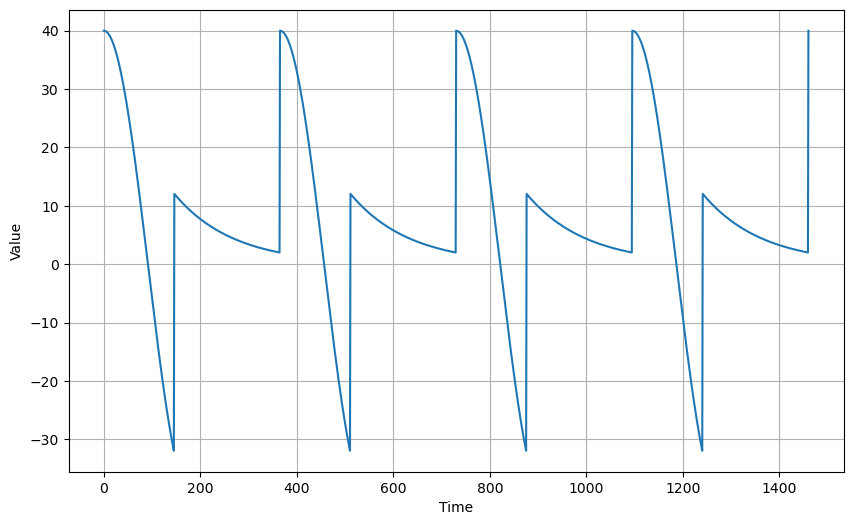

In [4]:
def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

# Generate time steps
time = np.arange(4 * 365 + 1)

# Define the parameters of the seasonal data
period = 365
amplitude = 40

# Generate the seasonal data
series = seasonality(time, period=period, amplitude=amplitude)

# Plot the results
plot_series(time, series)

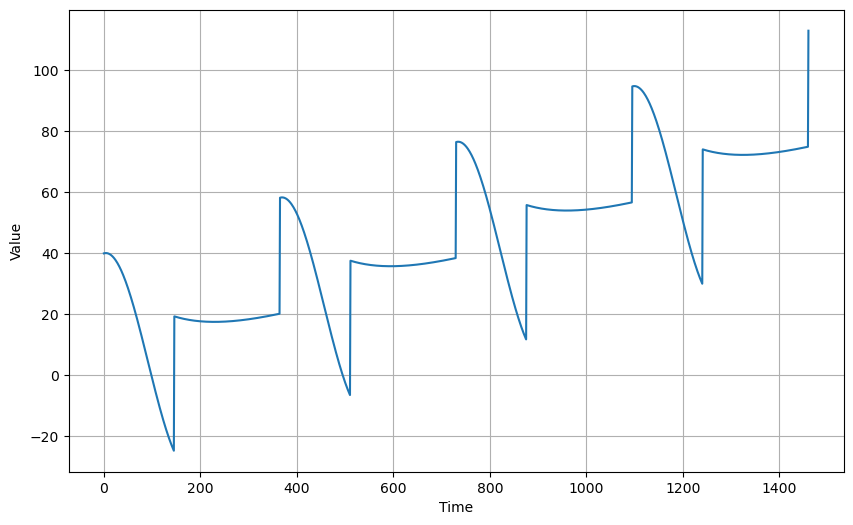

In [5]:
# A time series can also contain both trend and seasonality.
# Define seasonal parameters
slope = 0.05
period = 365
amplitude = 40

# Generate the data
series = trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)

# Plot the results
plot_series(time, series)

## Noise

In practice, few real-life time series have such a smooth signal. They usually have some noise riding over that signal. The next cells will show what a noisy signal looks like:

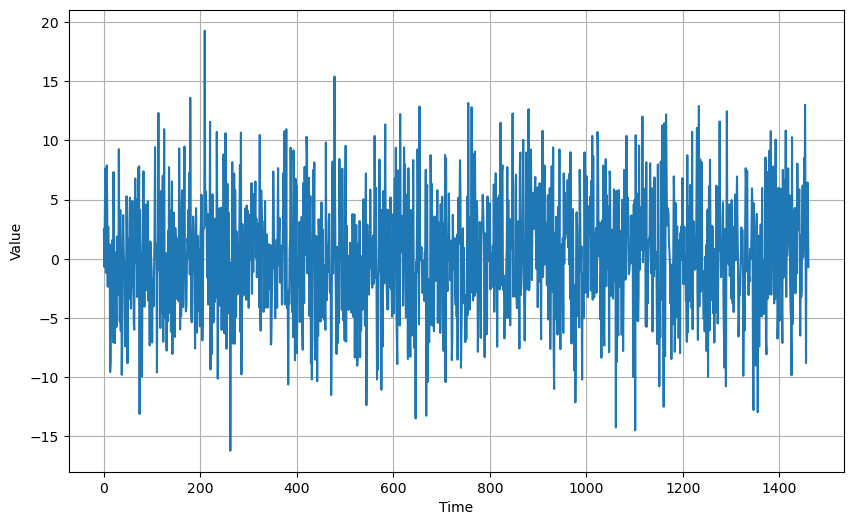

In [6]:
def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal

    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

# Define noise level
noise_level = 5

# Generate noisy signal
noise_signal = noise(time, noise_level=noise_level, seed=42)

# Plot the results
plot_series(time, noise_signal)


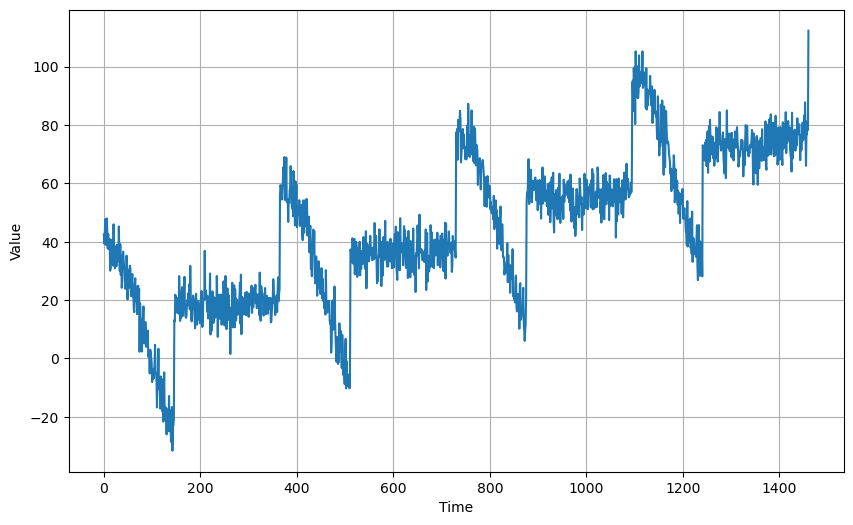

In [7]:
# Add the noise to the time series with trend and seasonality
series += noise_signal

# Plot the results
plot_series(time, series)

## Autocorrelation

Time series can also be autocorrelated. This means that measurements at a given time step is a function of previous time steps. Here are some functions that demonstrate that. Notice lines that refer to the `step` variable because this is where the computation from previous time steps happen. It will also include noise (i.e. random numbers) to make the result a bit more realistic.

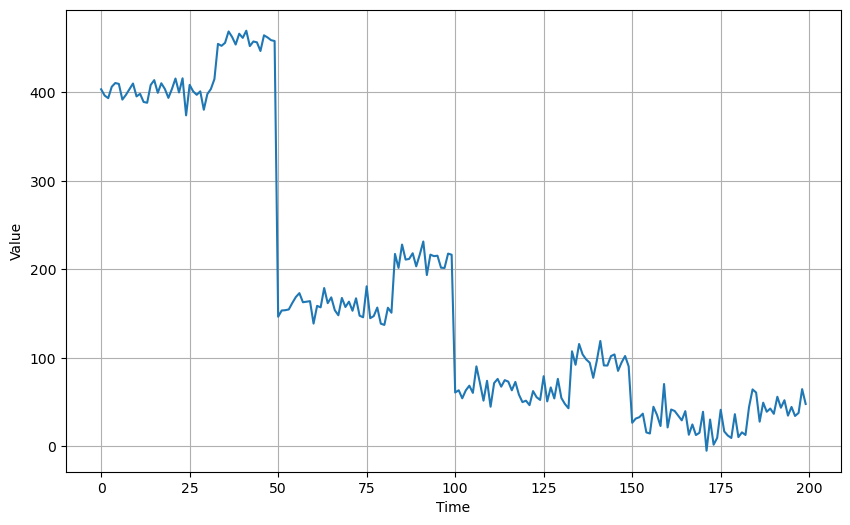

In [8]:
def autocorrelation(time, amplitude, seed=None):
    """
    Generates autocorrelated data

    Args:
      time (array of int) - contains the time steps
      amplitude (float) - scaling factor
      seed (int) - number generator seed for repeatability

    Returns:
      ar (array of float) - autocorrelated data
    """

    # Initialize random number generator 
    rnd = np.random.RandomState(seed)
    
    # Initialize array of random numbers equal to the length 
    # of the given time steps plus 50
    ar = rnd.randn(len(time) + 50)
    
    # Set first 50 elements to a constant
    ar[:50] = 100
    
    # Define scaling factors
    phi1 = 0.5
    phi2 = -0.1

    # Autocorrelate element 51 onwards with the measurement at 
    # (t-50) and (t-30), where t is the current time step
    for step in range(50, len(time) + 50):
        ar[step] += phi1 * ar[step - 50]
        ar[step] += phi2 * ar[step - 33]
    
    # Get the autocorrelated data and scale with the given amplitude.
    # The first 50 elements of the original array is truncated because
    # those are just constant and not autocorrelated.
    ar = ar[50:] * amplitude

    return ar

# Use time steps from previous section and generate autocorrelated data
series = autocorrelation(time, amplitude=10, seed=42)

# Plot the first 200 elements to see the pattern more clearly
plot_series(time[:200], series[:200])

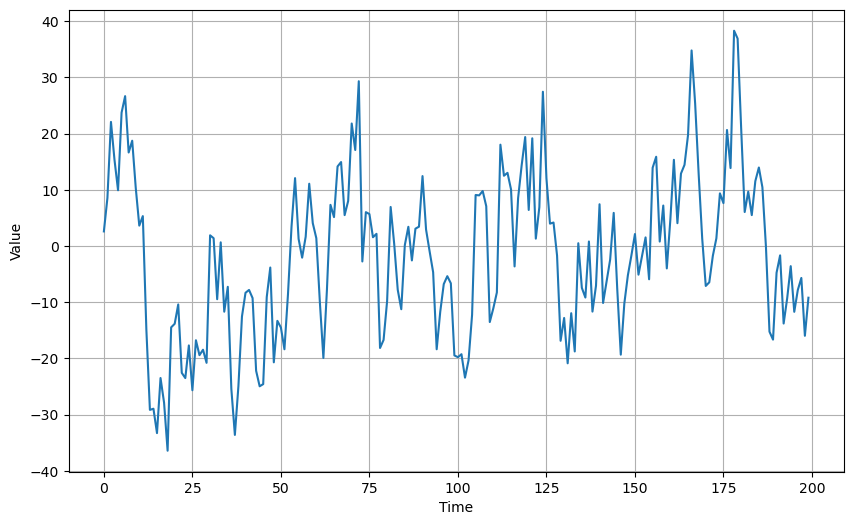

In [9]:
# Here is a more straightforward autocorrelation function which just computes a value from the previous time step.

def autocorrelation(time, amplitude, seed=None):
    """
    Generates autocorrelated data

    Args:
      time (array of int) - contains the time steps
      amplitude (float) - scaling factor
      seed (int) - number generator seed for repeatability

    Returns:
      ar (array of float) - generated autocorrelated data
    """

    # Initialize random number generator 
    rnd = np.random.RandomState(seed)

    # Initialize array of random numbers equal to the length 
    # of the given time steps plus an additional step
    ar = rnd.randn(len(time) + 1)

    # Define scaling factor
    phi = 0.8

    # Autocorrelate element 11 onwards with the measurement at 
    # (t-1), where t is the current time step
    for step in range(1, len(time) + 1):
        ar[step] += phi * ar[step - 1]
    
    # Get the autocorrelated data and scale with the given amplitude.
    ar = ar[1:] * amplitude
    
    return ar

# Use time steps from previous section and generate autocorrelated data
series = autocorrelation(time, amplitude=10, seed=42)

# Plot the results
plot_series(time[:200], series[:200])

Another autocorrelated time series you might encounter is one where it decays predictably after random spikes. You will first define the function that generates these spikes below.

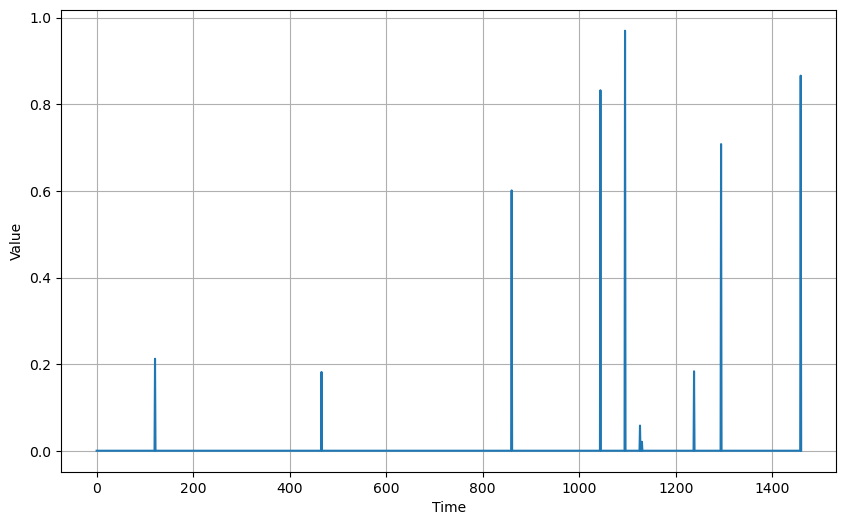

In [10]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    """
    Generates random impulses

    Args:
      time (array of int) - contains the time steps
      num_impulses (int) - number of impulses to generate
      amplitude (float) - scaling factor
      seed (int) - number generator seed for repeatability

    Returns:
      series (array of float) - array containing the impulses
    """

    # Initialize random number generator 
    rnd = np.random.RandomState(seed)

    # Generate random numbers
    impulse_indices = rnd.randint(len(time), size=num_impulses)

    # Initialize series
    series = np.zeros(len(time))

    # Insert random impulses
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude

    return series    
# Generate random impulses
impulses_signal = impulses(time, num_impulses=10, seed=42)

# Plot the results
plot_series(time, impulses_signal)

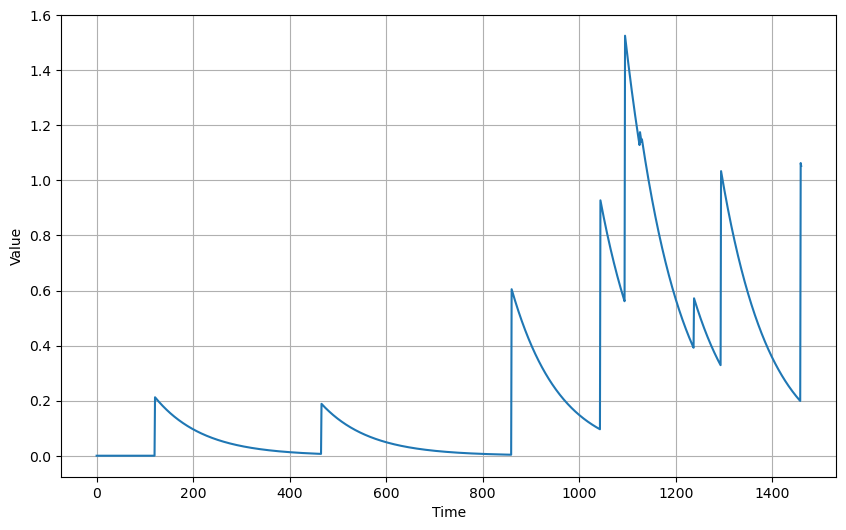

In [11]:
def autocorrelation_impulses(source, phis):
    """
    Generates autocorrelated data from impulses

    Args:
      source (array of float) - contains the time steps with impulses
      phis (dict) - dictionary containing the lag time and decay rates

    Returns:
      ar (array of float) - generated autocorrelated data
    """

    # Copy the source
    ar = source.copy()

    # Compute new series values based on the lag times and decay rates
    for step, value in enumerate(source):
        for lag, phi in phis.items():
            if step - lag > 0:
              ar[step] += phi * ar[step - lag]

    return ar

# Use the impulses from the previous section and generate autocorrelated data
series = autocorrelation_impulses(impulses_signal, {1: 0.99})

# Plot the results
plot_series(time, series)

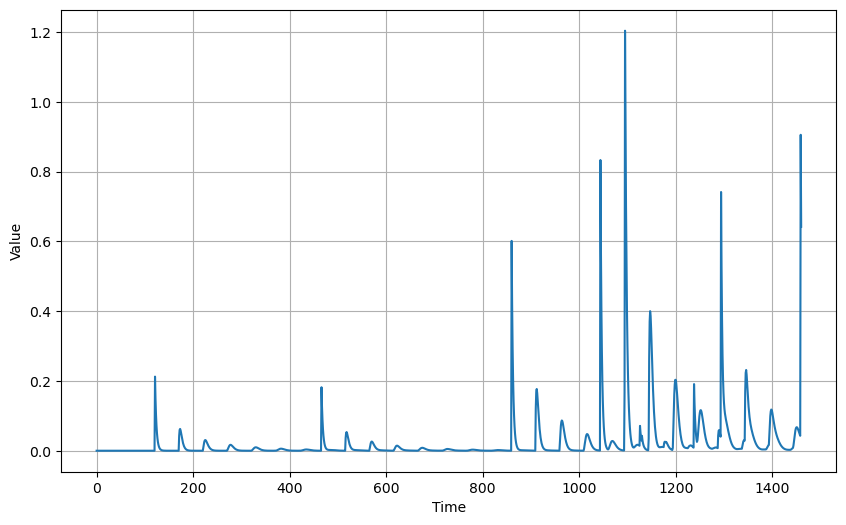

In [12]:
# Use the impulses from the previous section and generate autocorrelated data
series = autocorrelation_impulses(impulses_signal, {1: 0.70, 50: 0.2})

# Plot the results
plot_series(time, series)

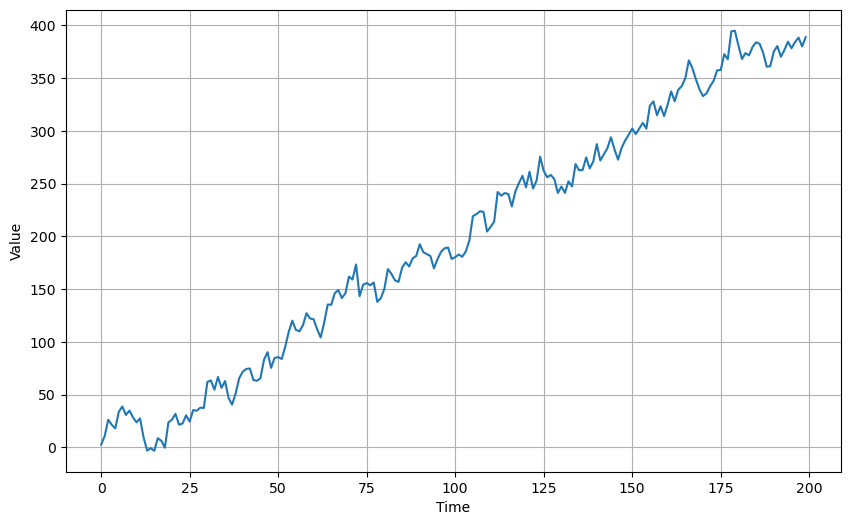

In [13]:
# Generate autocorrelated data with an upward trend
series = autocorrelation(time, 10, seed=42) + trend(time, 2)

# Plot the results
plot_series(time[:200], series[:200])

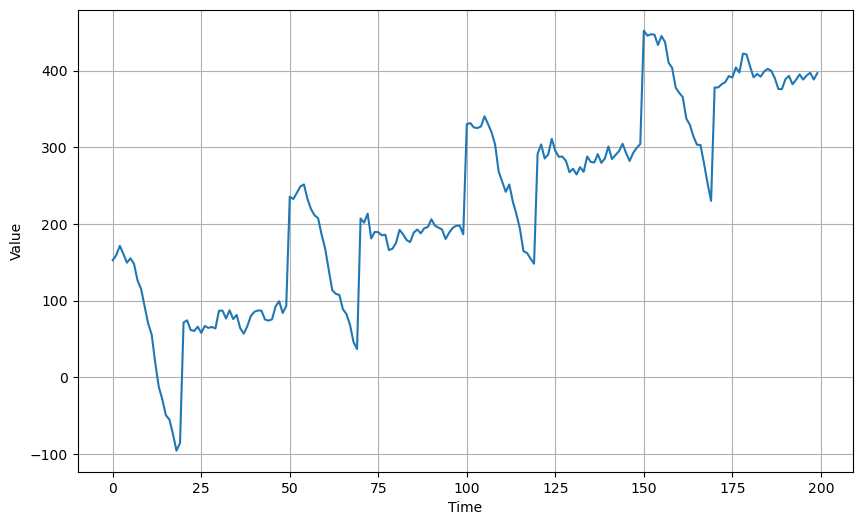

In [14]:
# Generate autocorrelated data with an upward trend
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)

# Plot the results
plot_series(time[:200], series[:200])


## Non-stationary Time Series

It is also possible for the time series to break an expected pattern. As mentioned in the lectures, big events can alter the trend or seasonal behavior of the data. It would look something like below where the graph shifted to a downward trend at time step = 200.

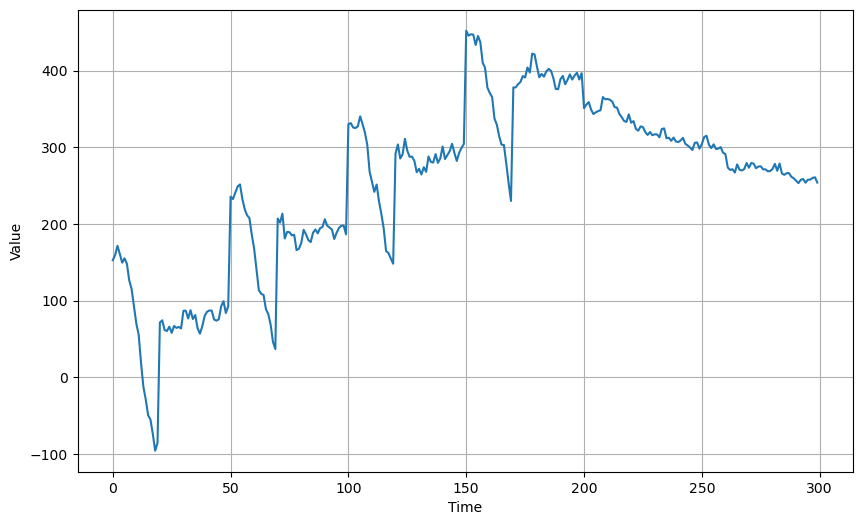

In [15]:
# Generate data with positive trend
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)

# Generate data with negative trend
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550

# Splice the downward trending data into the first one at time step = 200
series[200:] = series2[200:]

# Plot the result
plot_series(time[:300], series[:300])

## Training
To measure the performance of our forecasting model,. We typically want to split the time series into a training period, a validation period and a test period. This is called fixed partitioning.

If the time series has some seasonality, you generally want to ensure that each period contains a whole number of seasons.

Next you'll train your model on the training period, and you'll evaluate it on the validation period. Here's where you can experiment to find the right architecture for training. And work on it and your hyper parameters, until you get the desired performance, measured using the validation set. Often, once you've done that, you can retrain using both the training and validation data. And then test on the test period to see if your model will perform just as well. And if it does, then you could take the unusual step of retraining again, using also the test data. But why would you do that? Well, it's because the test data is the closest data you have to the current point in time. And as such it's often the strongest signal in determining future values. If your model is not trained using that data, too, then it may not be optimal. Due to this, it's actually quite common to forgo a test set all together. And just train, using a training period and a validation period, and the test set is in the future. 

There's also another way. We start with a short training period, and we gradually increase it, say by one day at a time, or by one week at a time. At each iteration, we train the model on a training period. And we use it to forecast the following day, or the following week, in the validation period. And this is called roll-forward partitioning.

## Metrics

Errors, which is the difference between the forecasted values from our model and the actual values over the evaluation period.

* $error = forecasts - actual$

* $mse = np.mean(error^2)$

* $rmse = np.sqrt(mse)$

mean absolute deviation or MAE ( does not penalize large errors as much as the mse does.):

* $mae = np.abs(error).mean()$

Depending on your task, you may prefer the mae or the mse. For example, if large errors are potentially dangerous and they cost you much more than smaller errors, then you may prefer the mse. But if your gain or your loss is just proportional to the size of the error, then the mae may be better.

* $mape = np.abs(error / x_valid).mean()$

## Moving average and differencing

Calculating the moving average over the data using a fixed period of time. Eg averaging over the first n days the move one more step and average over the next n days and continue in that fashion. Now this nicely eliminates a lot of the noise and it gives us a curve roughly emulating the original series, but it does not anticipate trend or seasonality and result in bad performance. One method to avoid this is to remove the trend and seasonality from the time series with a technique called differencing. So instead of studying the time series itself, we study the difference between the value at time T and the value at an earlier period. Now you can use the moving window to forecast. To get the final forecasts for the original time series, we just need to add back the value at time T minus earlier time chosen, and we'll get these forecasts. 

Moving averages using centered windows can be more accurate than using trailing windows.


# Statistical Forecasting

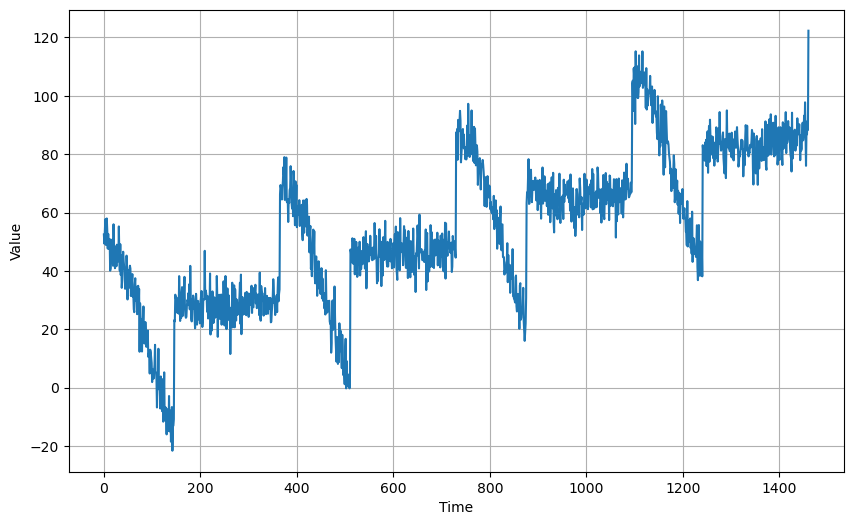

In [16]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
  """
  Generates synthetic data that follows a straight line given a slope value.

  Args:
    time (array of int) - contains the time steps
    slope (float) - determines the direction and steepness of the line

  Returns:
    series (array of float) - measurements that follow a straight line
  """

  # Compute the linear series given the slope
  series = slope * time

  return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)


In [17]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

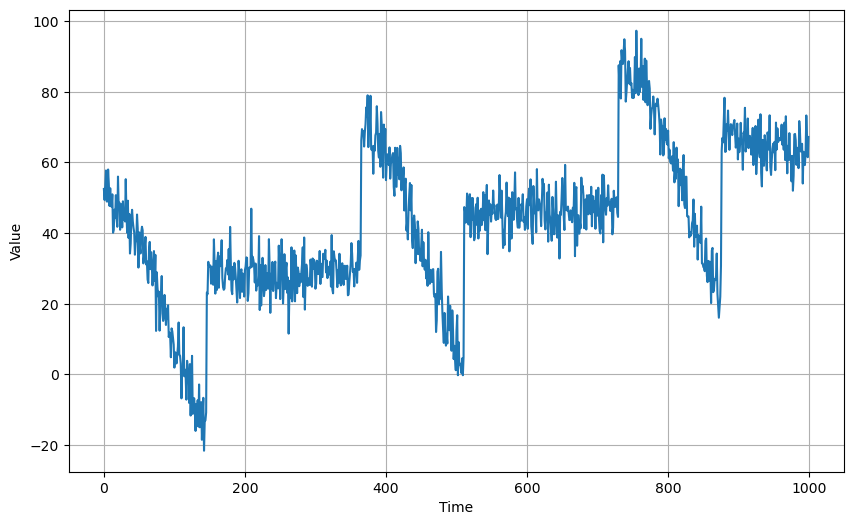

In [18]:
# Plot the train set
plot_series(time_train, x_train)

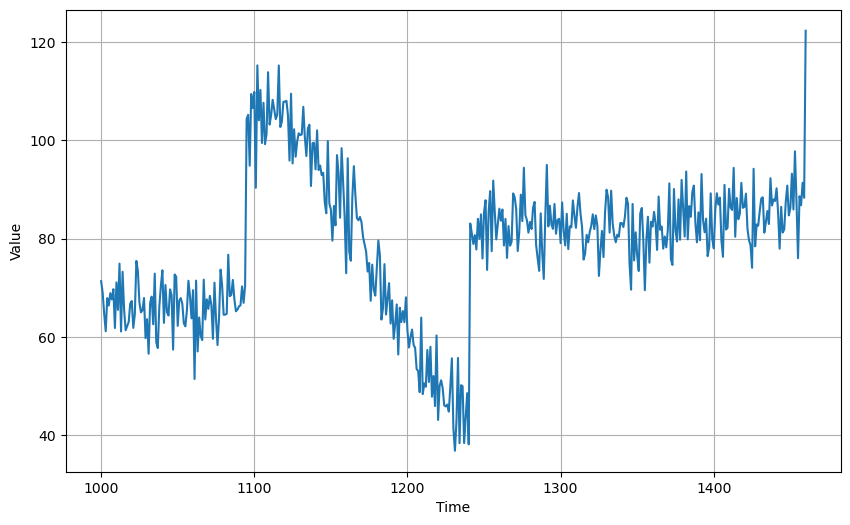

In [19]:
# Plot the validation set
plot_series(time_valid, x_valid)

# Naive Forecast

As a baseline - that we can try to beat with ML-, you can do a naive forecast where you assume that the next value will be the same as the previous time step. You can slice the original series like below and print some values as a sanity check. The next time step value should be identical to the ground truth at the previous time step.

This series should be identical to the validation one but delayed one time step. It also receives the split time step of the series for ease of computing the delayed series.

**Notice that this series should leave out the last element since this element does not exists in the validation set and you will not be able to compute the evaluation metrics if this element is kept.**

In [20]:
# Generate the naive forecast
naive_forecast = series[split_time - 1:-1]

# Define time step
time_step = 100

# Print values
print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')


ground truth at time step 100: 109.84197998046875
prediction at time step 101: 109.84197998046875


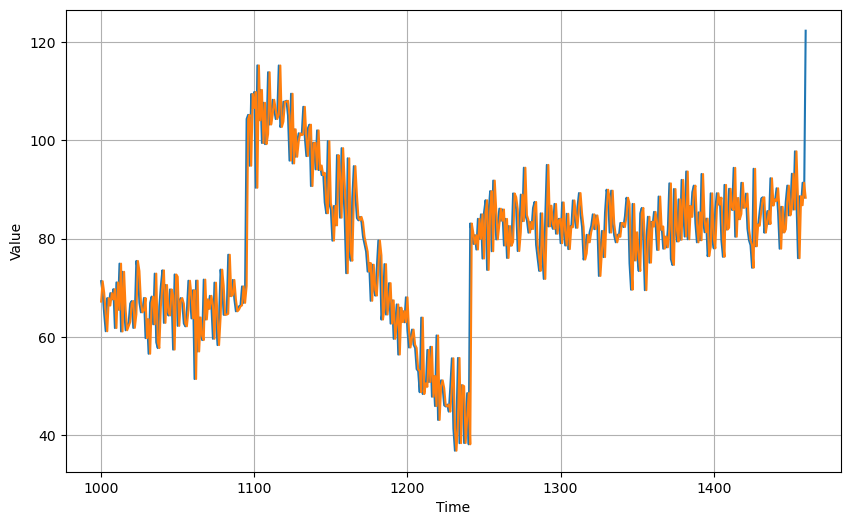

In [21]:
# Plot the results
plot_series(time_valid, (x_valid, naive_forecast))

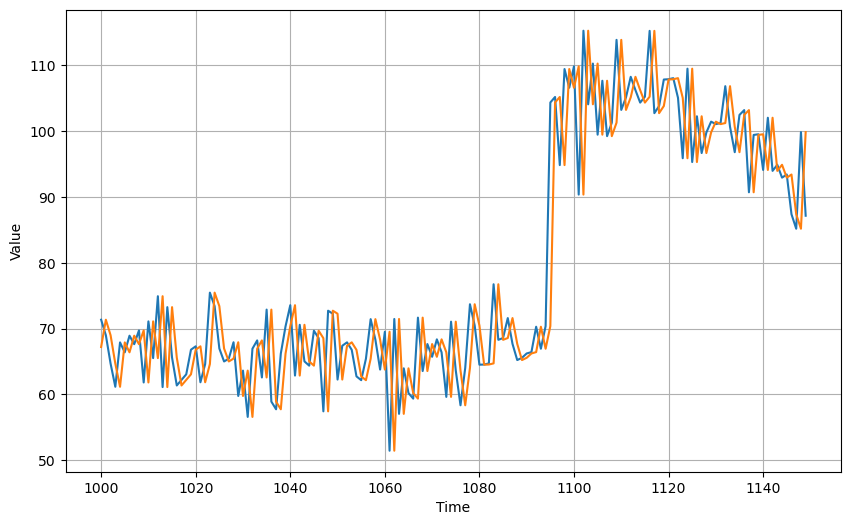

In [22]:
# Zooming in
#  You can zoom in at the start of the validation period to see that the naive forecast lags 1 step behind the time series.
plot_series(time_valid, (x_valid, naive_forecast), start=0, end=150)

In [23]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())
# The values below will be your baseline and you will see if you can use other methods to do better than naive forecasting.

61.827526
5.9379086


2023-11-01 12:40:22.064258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 12:40:22.064918: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Moving Average

One technique you can use is to do a moving average. This sums up a series of time steps and the average will be the prediction for the next time step. For example, the average of the measurements at time steps 1 to 10 will be the forecast for time step 11, then the average for time steps 2 to 11 will be the forecast for time step 12, and so on.


(461,) (461,) (461,)


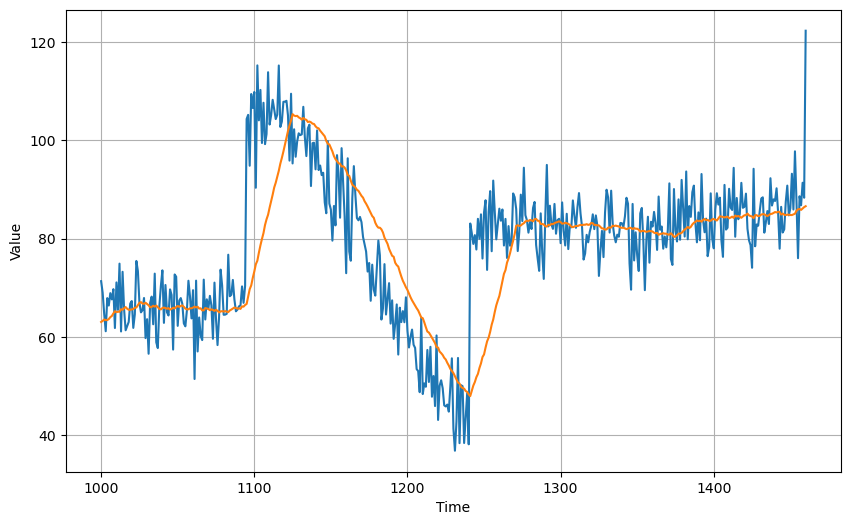

In [24]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []
    
    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())
    
    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast


# Generate the moving average forecast
# You will use this function to generate the forecast with a window size of 30.

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]
print(moving_avg.shape, time_valid.shape, x_valid.shape)
# Plot the results
plot_series(time_valid, (x_valid, moving_avg))

In [25]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.67457
7.142419


That's worse than naive forecast! The moving average does not anticipate trend or seasonality. In particular, those huge spikes in the original series causes big deviations as shown in the plot above. You will try to remove these characteristics of the dataset with time differencing and see if you get better results.

## Differencing

Since the seasonality period is 365 days, you will subtract the value at time *t* – 365 from the value at time *t*. That is done with the code below. 

In addition, you will need to align the result with the `time` array. Since you can only do time differencing for `t >= 365`, you will need to truncate the first 365 time steps of the `time` array.

You can plot the result to visualize the values.

In [26]:
series[:-365].shape, series[365:].shape, 
g = np.arange(10)
g, g[4:], g[:-4], series.shape,series[:-365].shape, series[365:].shape, #g[1:].mean(), g[:-1].mean()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5]),
 (1461,),
 (1096,),
 (1096,))

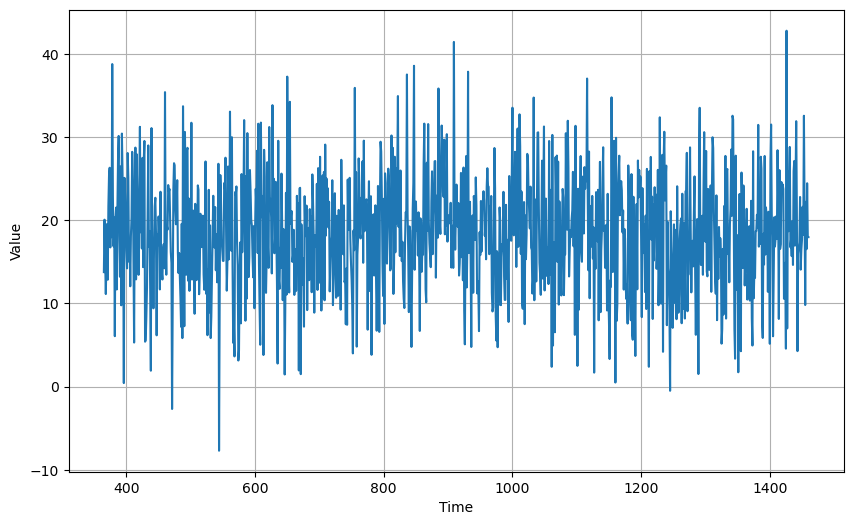

In [27]:
# Subtract the values at t-365 from original series
# Great! The trend and seasonality seem to be gone so now you can retry using the moving average. `diff_series` is the ground truth while `diff_moving_avg` is the prediction array. You will slice these accordingly to correspond to the validation set time steps before comparing.
diff_series = (series[365:] - series[:-365])

# Truncate the first 365 time steps
diff_time = time[365:]

# Plot the results
plot_series(diff_time, diff_series)

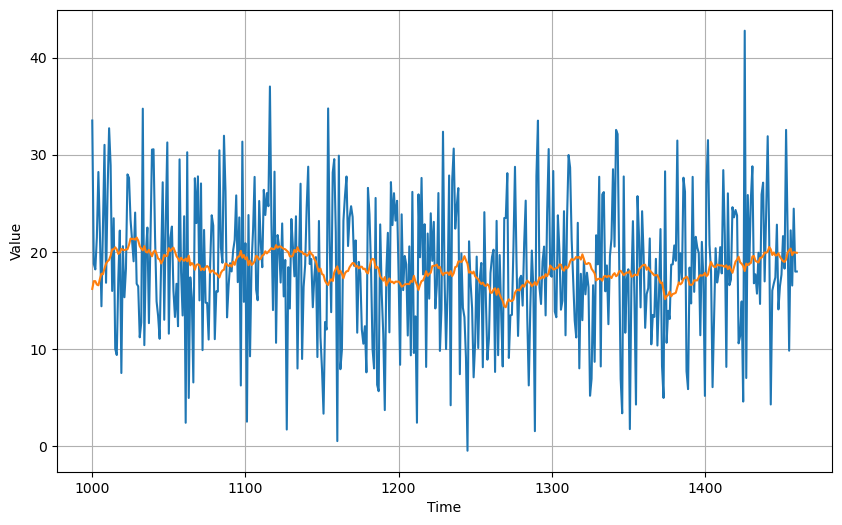

In [28]:
# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 30)

# Slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - 30:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 365:]

# Plot the results
plot_series(time_valid, (diff_series, diff_moving_avg))

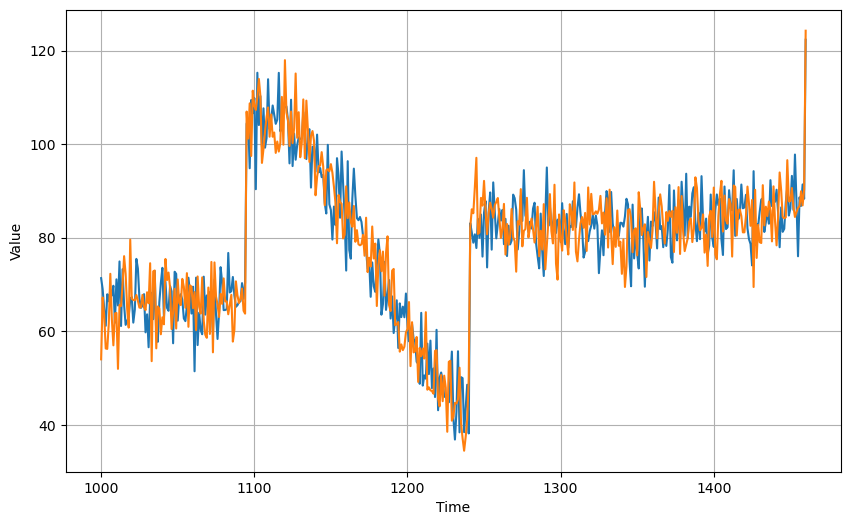

In [29]:
# Now you will bring back the trend and seasonality by adding the past values from `t – 365`:
# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_past))

In [30]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

53.764584
5.9032416


It is a bit better than naive forecast. However, the forecasts look a bit too random because you're adding past values which are already noisy. Remember that the time differenced signal is also noisy so adding these raw past values can compound this problem. To remedy that, you can use a moving averaging on past values to smooth out some of this noise.

## Smoothing

You can use the same `moving_average_forecast()` function to smooth out past values before adding them back to the time differenced moving average. There are two ways to do this:

* Trailing windows - This refers to getting the mean of past values to smooth out the value at the current time step. For example, getting the average of `t=0` to `t=6` to get the smoothed data point at **`t=6`**.

* Centered windows - This refers to getting the mean of past *and future* values to smooth out the value at the current time step. For example, getting the average of `t=0` to `t=6` to get the smoothed data point at **`t=3`**.

The code below will use the centered windows approach and you will notice it in the slicing of the `series` array. It is shifted by `370` steps and the window size is `11`. To get the smooth data point at `t=1000` (i.e. start of the validation set), it will average the measurements at `t=995` to `t=1005`.

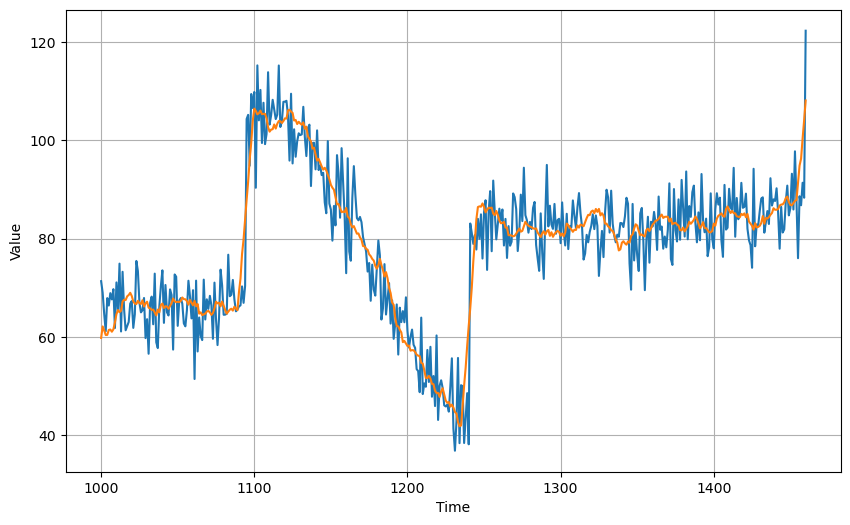

In [31]:
# Smooth the original series before adding the time differenced moving average
# Moving averages using centered windows can be more accurate than using trailing windows. You will use the moving average forecast but this time you will use a centered window. That is, the window will be equally split between the past and future.
# But we can't use centered windows to smooth present values since we don't know future values. However, to smooth past values we can afford to use centered windows.

diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg # centered window
# diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 365:-354], 11) + diff_moving_avg # trailing window

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_smooth_past))

In [32]:
 # Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

34.315723
4.6053295


In [33]:
34.315723
4.6053295

4.6053295

## AI Forecasting

In [34]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Preview the result
for val in dataset:
   print(val.numpy())

0
1
2
3
4
5
6
7
8
9


## Windowing the data

As mentioned earlier, you want to group consecutive elements of your data and use that to predict a future value. This is called windowing and you can use that with the [window()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) method as shown below. Here, you will take 5 elements per window (i.e. `size` parameter) and you will move this window 1 element at a time (i.e. `shift` parameter). One caveat to using this method is that each window returned is a [Dataset](https://www.tensorflow.org/guide/data#dataset_structure) in itself. This is a Python iterable and, as of the current version (TF 2.8), it won't show the elements if you use the `print()` method on it. It will just show a description of the data structure (e.g. `<_VariantDataset shapes: (), types: tf.int64>`).

In [69]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Window the data
dataset = dataset.window(size=5, shift=1)

# Print the result
for window_dataset in dataset:
  print(window_dataset)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [70]:
# Print the result
for window_dataset in dataset:
  print([item.numpy() for item in window_dataset])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]
[6, 7, 8, 9]
[7, 8, 9]
[8, 9]
[9]


2023-10-31 13:22:43.190986: W tensorflow/core/framework/dataset.cc:769] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [71]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Window the data but only take those with the specified size
dataset = dataset.window(size=5, shift=1, drop_remainder=True)

# Print the result
for window_dataset in dataset:
  print([item.numpy() for item in window_dataset])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


2023-10-31 13:24:13.943999: W tensorflow/core/framework/dataset.cc:769] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


## Flatten the Windows

In training the model later, you will want to prepare the windows to be [tensors](https://www.tensorflow.org/guide/tensor) instead of the `Dataset` structure. You can do that by feeding a mapping function to the [flat_map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#flat_map) method. This function will be applied to each window and the results will be [flattened into a single dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#flatten_a_dataset_of_windows_2). To illustrate, the code below will put all elements of a window into a single batch then flatten the result.

In [72]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Print the results
for window in dataset:
  print(window.numpy())

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


## Group into features and labels


In [74]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# Print the results
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

x =  [0 1 2 3]
y =  4

x =  [1 2 3 4]
y =  5

x =  [2 3 4 5]
y =  6

x =  [3 4 5 6]
y =  7

x =  [4 5 6 7]
y =  8

x =  [5 6 7 8]
y =  9



## Shuffle the data

It is good practice to shuffle your dataset to reduce *sequence bias* while training your model. This refers to the neural network overfitting to the order of inputs and consequently, it will not perform well when it does not see that particular order when testing. You don't want the sequence of training inputs to impact the network this way so it's good to shuffle them up. 

You can simply use the [shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) method to do this. The `buffer_size` parameter is required for that and as mentioned in the doc, you should put a number equal or greater than the total number of elements for better shuffling. We can see from the previous cells that the total number of windows in the dataset is `6` so we can choose this number or higher.

In [79]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# Shuffle the windows
dataset = dataset.shuffle(buffer_size=10)

# Print the results
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()


x =  [5 6 7 8]
y =  9

x =  [2 3 4 5]
y =  6

x =  [0 1 2 3]
y =  4

x =  [4 5 6 7]
y =  8

x =  [1 2 3 4]
y =  5

x =  [3 4 5 6]
y =  7



In [35]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# Shuffle the windows
dataset = dataset.shuffle(buffer_size=10)

# Create batches of windows
dataset = dataset.batch(6).prefetch(1)

# Print the results
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


x =  [[4 5 6 7]
 [2 3 4 5]
 [5 6 7 8]
 [3 4 5 6]
 [0 1 2 3]
 [1 2 3 4]]
y =  [8 6 9 7 4 5]



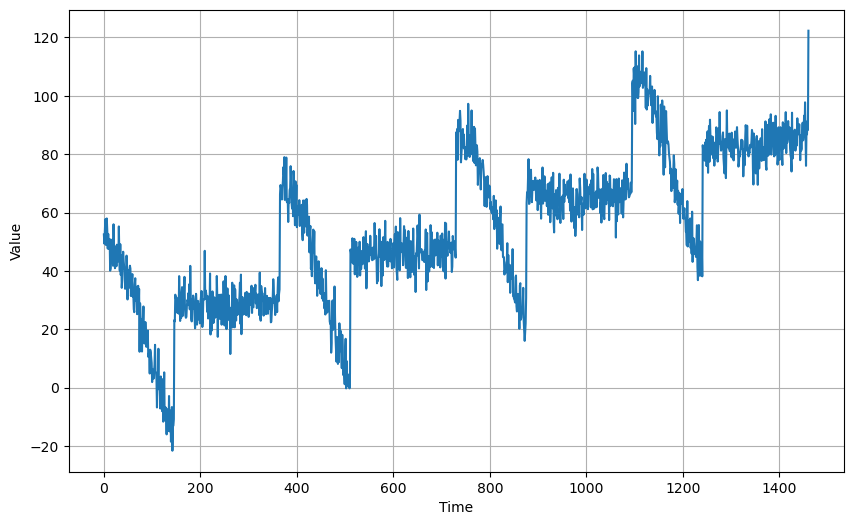

In [80]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

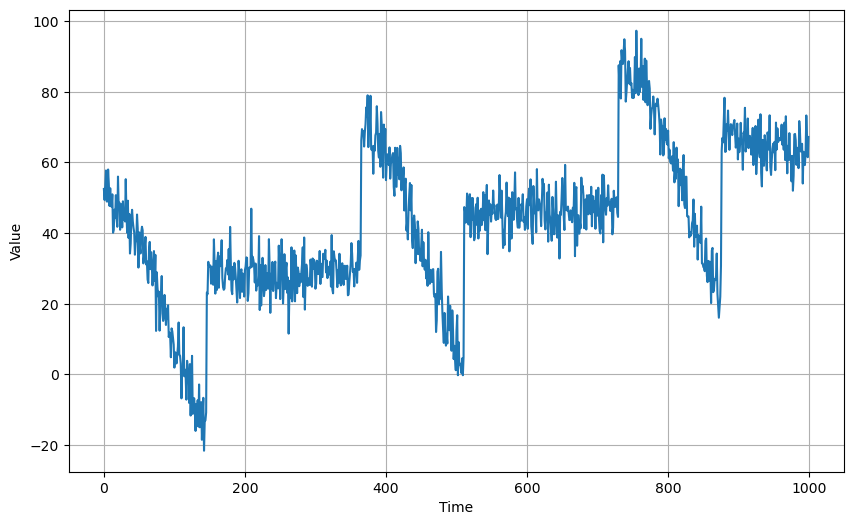

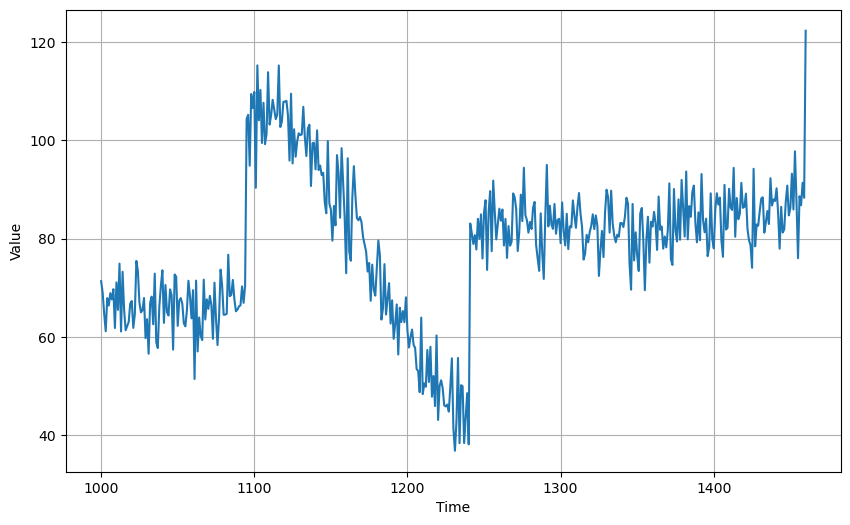

In [81]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Plot the train set
plot_series(time_train, x_train)

# Plot the validation set
plot_series(time_valid, x_valid)

In [37]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-11-01 16:12:54.491210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 16:12:54.491684: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


You can again inspect the output to see if the function is behaving as expected. The code below will use the [`take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) method of the `tf.data.Dataset` API to grab a single batch. It will then print several properties of this batch such as the data type and shape of the elements. As expected, it should have a 2-element tuple (i.e. `(feature, label)`) and the shapes of these should align with the batch and window sizes you declared earlier which are `32` and `20` by default, respectively.

In [84]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


## Build and compile the model

Next, you will build the single layer neural network. This will just be a one-unit [Dense](https://keras.io/api/layers/core_layers/dense/) layer as shown below. You will assign the layer to a variable `l0` so you can also look at the final weights later using the [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) method.

In [85]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[ 0.1428625 ],
       [-0.41956246],
       [-0.44056332],
       [-0.33204693],
       [ 0.4982565 ],
       [-0.519191  ],
       [-0.05847639],
       [ 0.4935189 ],
       [ 0.2591697 ],
       [ 0.5162204 ],
       [-0.07455575],
       [ 0.15774238],
       [ 0.21551812],
       [ 0.23749584],
       [-0.42893454],
       [-0.11381751],
       [ 0.09939587],
       [-0.37765315],
       [ 0.46867985],
       [ 0.1850946 ]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


You will set [*mean squared error (mse)*](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) as the loss function and use [*stochastic gradient descent (SGD)*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) to optimize the weights during training.

In [86]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

## Train the Model

Now you can proceed to train your model. You will feed in the prepared data windows and run the training for 100 epochs.

In [87]:
# Train the model
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 258.8942
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 152.7513
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 137.5038
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 128.5846
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 124.0363
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 116.6140
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 110.8613
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 103.8533
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 99.7209
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 97.2844
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 93.5354
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 88.7266
Epoch 13/100
31/3

In [88]:
#You can see the final weights by again calling the `get_weights()` method.
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.0294649 ],
       [-0.0506374 ],
       [-0.0138809 ],
       [-0.02725856],
       [ 0.15085816],
       [-0.09150388],
       [-0.04797572],
       [ 0.0596268 ],
       [ 0.00599858],
       [ 0.06231514],
       [-0.06783689],
       [-0.014083  ],
       [ 0.0026973 ],
       [ 0.0842779 ],
       [-0.05074139],
       [ 0.04891349],
       [ 0.0697916 ],
       [ 0.10316627],
       [ 0.334072  ],
       [ 0.43946853]], dtype=float32), array([0.01553378], dtype=float32)]


## Model Prediction

With the training finished, you can now measure the performance of your model. You can generate a model prediction by passing a batch of data windows. If you will be slicing a window from the original `series` array, you will need to add a batch dimension before passing it to the model. That can be done by indexing with the [`np.newaxis`](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) constant or using the [`np.expand_dims()`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) method.

In [89]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 83ms/step
model prediction: [[45.00363]]


To compute the metrics, you will want to generate model predictions for your validation set. Remember that this set refers to points at index `1000` to `1460` of the entire series. You will need to code the steps to generate those from your model. The cell below demonstrates one way of doing that. 

Basically, it feeds the entire series to your model 20 points at a time and append all results to a `forecast` list. It will then slice the points that corresponds to the validation set. 

The slice index below is `split_time - window_size:` because the forecast list is smaller than the series by 20 points (i.e. the window size). Since the window size is 20, the first data point in the `forecast` list corresponds to the prediction for time at index `20`. You cannot make predictions at index `0` to `19` because those are smaller than the window size. Thus, when you slice with `split_time - window_size:`, you will be getting the points at the time indices that aligns with those in the validation set.

*Note: You might notice that this cell takes a while to run. In the next two labs, you will see other approaches to generating predictions to make the code run faster. You might already have some ideas and feel free to try them out after completing this lab.*

In [90]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 20ms/step
length of the forecast list: 461
shape of the validation set: (461,)


To visualize the results, you will need to convert the predictions to a form that the `plot_series()` utility function accepts. That involves converting the list to a numpy array and dropping the single dimensional axes.

shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


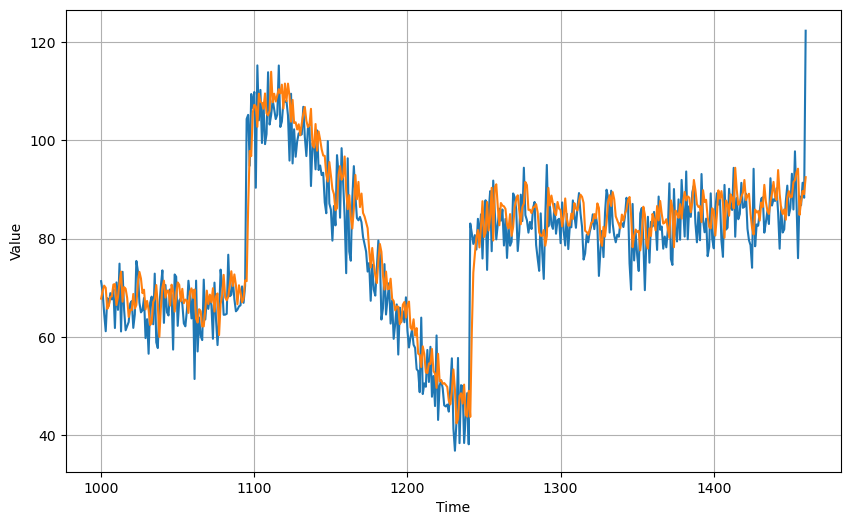

In [91]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

In [92]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

49.134613
5.4012756


## DNN with multiple layers

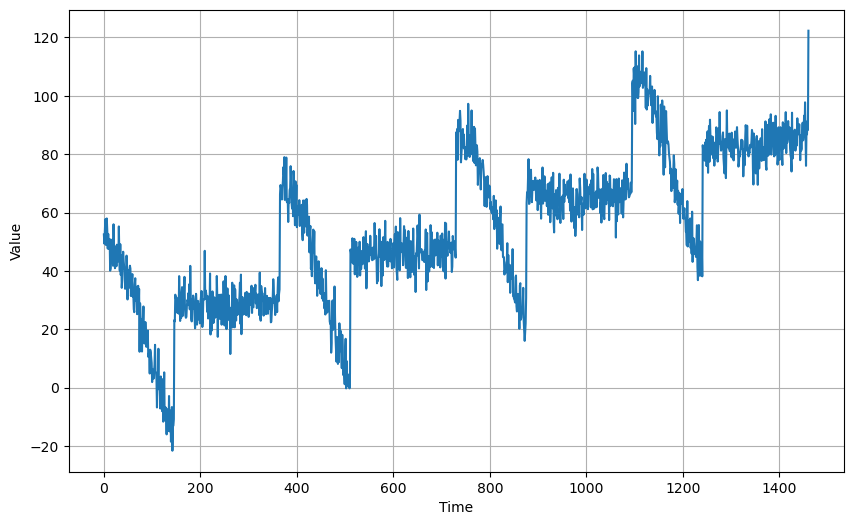

In [93]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [94]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [95]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

You will use three dense layers in this exercise as shown below. As expected, the number of trainable parameters will increase and the model summary shows that it is more than tenfold of the previous lab.

In [96]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [97]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

# Train the model
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 1466.6427
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 150.1557
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 130.8748
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 121.6570
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 114.8210
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 108.6074
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 104.0167
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 98.6873
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 94.6485
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 91.1454
Epoch 11/100
31/31 [==============================] - 0s 11ms/step - loss: 88.5234
Epoch 12/100
31/31 [==============================] - 1s 12ms/step - loss: 84.9725
Epoch 13/100
31

1/1 [==============================] - 0s 53ms/step


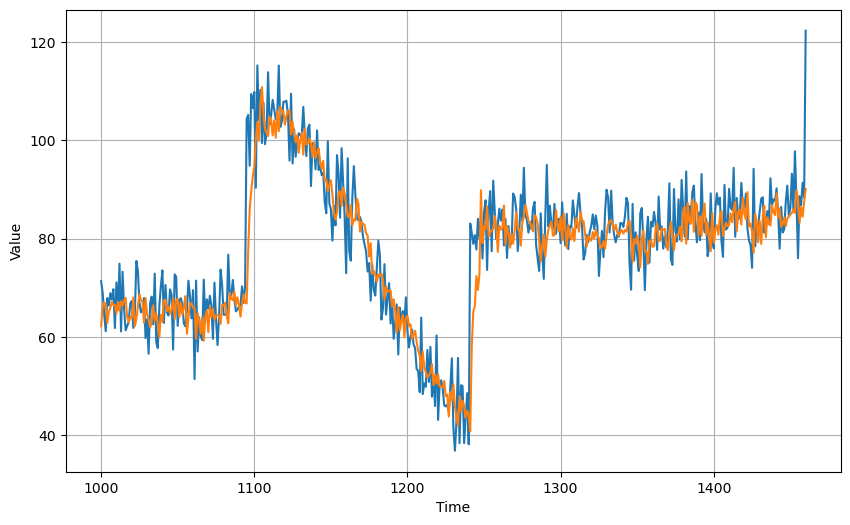

In [98]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [99]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

47.981716
5.0996556


## Tune the learning rate

You saw that the training went well with the initial learning rate that you chose (i.e. `1e-6`). However, you're not yet sure if it is the best setting for this particular model. It might seem inconsequential in this simple model but when you have more complex ones, spending some time to tune the learning rate can lead to better training results. You will see how to do that in this section.

First, you will build the same model architecture you just used.

In [100]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [101]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [102]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

In [103]:
# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 3389.9785 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 10ms/step - loss: 2021.8842 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 1166.1689 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 817.4940 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 621.6964 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 475.5775 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 366.6233 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 9ms/step - loss: 290.9263 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 240.5831 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 212.0580 - lr: 2.8184e-08


(1e-08, 0.001, 0.0, 300.0)

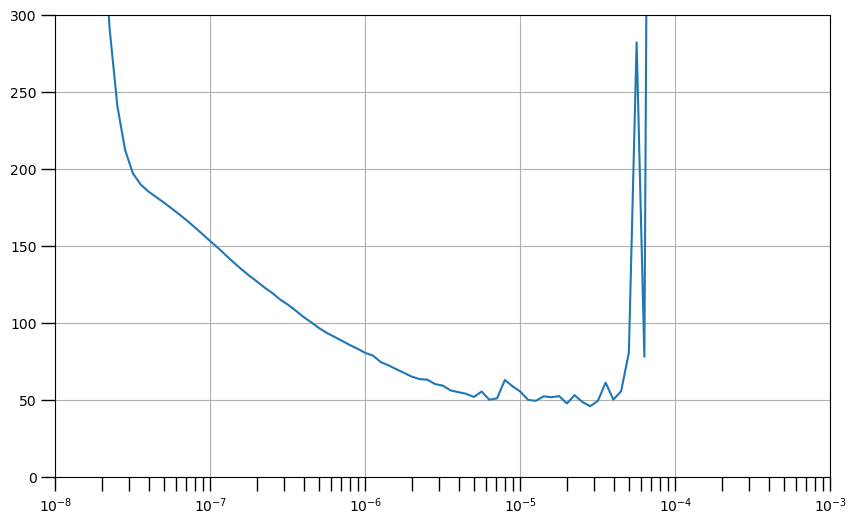

In [104]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

In [105]:
# Build the model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

In [106]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 12ms/step - loss: 355.6408
Epoch 2/100
31/31 [==============================] - 1s 10ms/step - loss: 79.6755
Epoch 3/100
31/31 [==============================] - 1s 12ms/step - loss: 71.0884
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 67.2392
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 63.8469
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 62.4466
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 59.9631
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 59.1974
Epoch 9/100
31/31 [==============================] - 1s 11ms/step - loss: 57.4952
Epoch 10/100
31/31 [==============================] - 1s 11ms/step - loss: 55.9317
Epoch 11/100
31/31 [==============================] - 1s 9ms/step - loss: 55.3460
Epoch 12/100
31/31 [==============================] - 0s 9ms/step - loss: 54.5655
Epoch 13/100
31/31

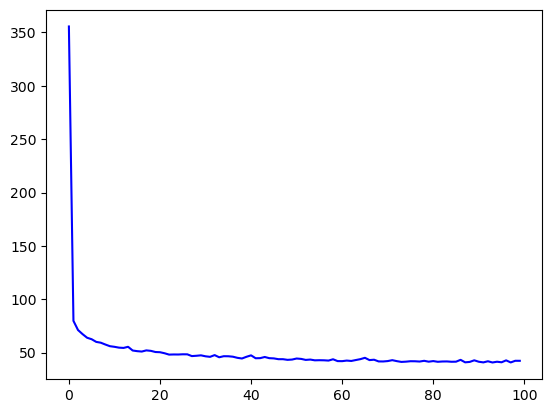

In [107]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

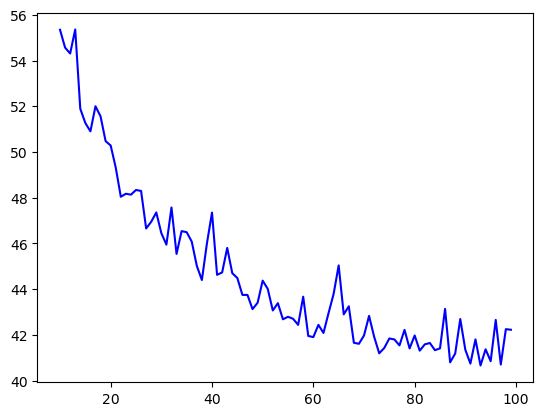

In [108]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 105ms/step


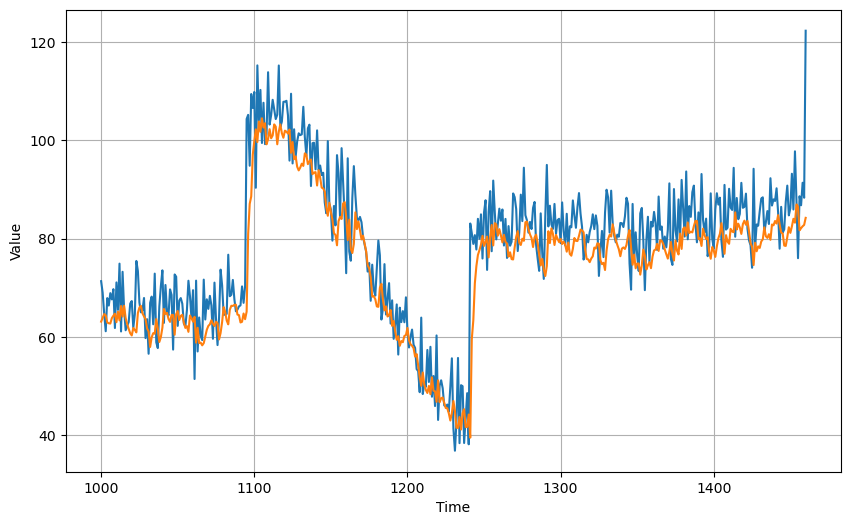

In [110]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [111]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

57.9486
5.62334


##  RNN (Recurrent NN)

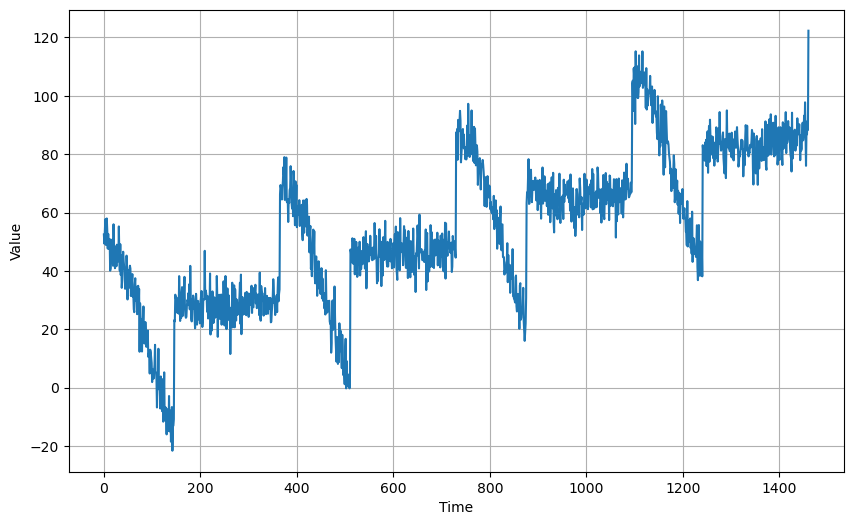

In [9]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [10]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [11]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [13]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [14]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


In [15]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 4s 39ms/step - loss: 18.9593 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 37ms/step - loss: 17.6767 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 36ms/step - loss: 16.9644 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 2s 48ms/step - loss: 16.6397 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 2s 42ms/step - loss: 16.4756 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 40ms/step - loss: 16.3624 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 2s 53ms/step - loss: 16.2758 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 2s 53ms/step - loss: 16.1811 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 2s 67ms/step - loss: 16.0827 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 2s 58ms/step - loss: 15.9721 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 50.0)

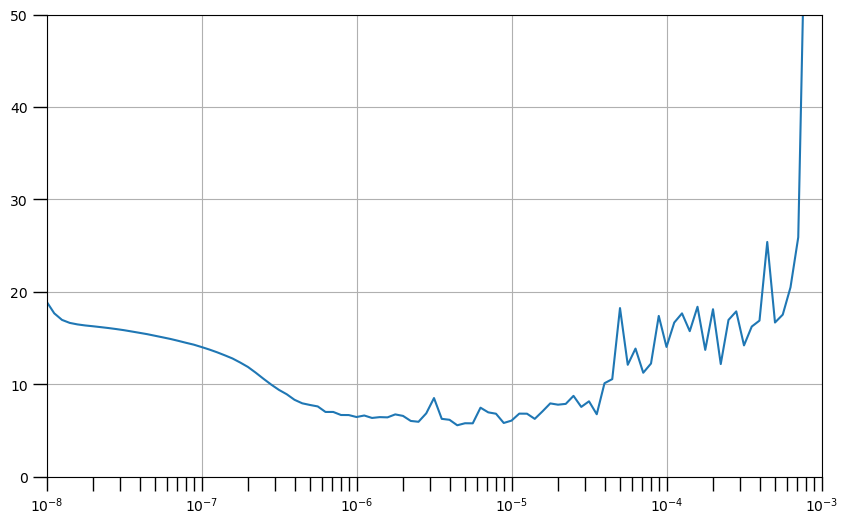

In [17]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [18]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 3s 42ms/step - loss: 14.3731 - mae: 14.8638
Epoch 2/100
31/31 [==============================] - 2s 55ms/step - loss: 10.1675 - mae: 10.6537
Epoch 3/100
31/31 [==============================] - 2s 40ms/step - loss: 9.1936 - mae: 9.6797
Epoch 4/100
31/31 [==============================] - 2s 49ms/step - loss: 8.6086 - mae: 9.0921
Epoch 5/100
31/31 [==============================] - 2s 61ms/step - loss: 7.9062 - mae: 8.3865
Epoch 6/100
31/31 [==============================] - 2s 64ms/step - loss: 7.7999 - mae: 8.2805
Epoch 7/100
31/31 [==============================] - 2s 49ms/step - loss: 7.6433 - mae: 8.1256
Epoch 8/100
31/31 [==============================] - 2s 56ms/step - loss: 7.3525 - mae: 7.8371
Epoch 9/100
31/31 [==============================] - 2s 45ms/step - loss: 7.2345 - mae: 7.7141
Epoch 10/100
31/31 [==============================] - 2s 59ms/step - loss: 7.3275 - mae: 7.8093
Epoch 11/100
31/31 [=========================

1/1 [==============================] - 0s 76ms/step


ValueError: x and y must have same first dimension, but have shapes (461,) and (2, 461)

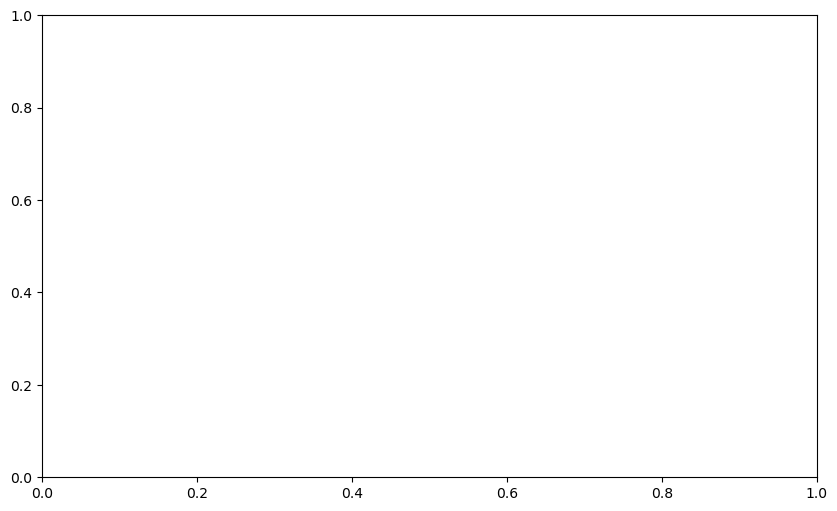

In [19]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

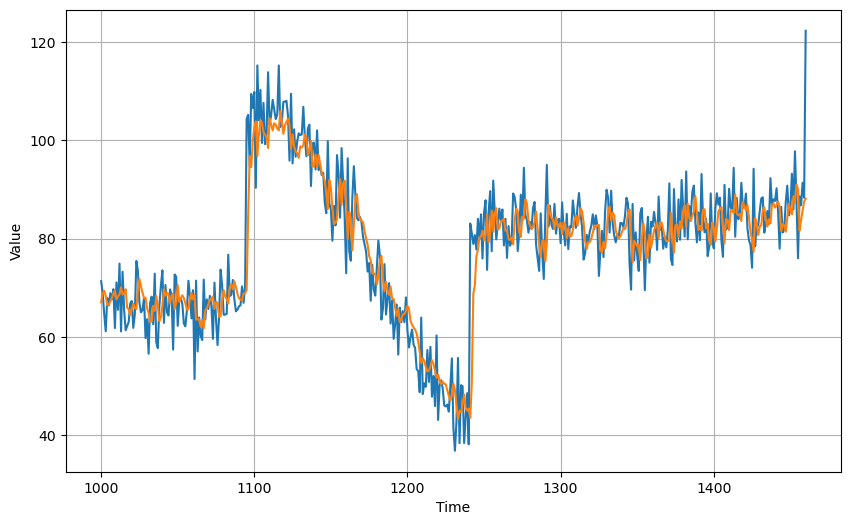

In [24]:
# Plot the results


plot_series(time_valid, (x_valid, results))

In [25]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

45.781063
4.9796624


## RNN

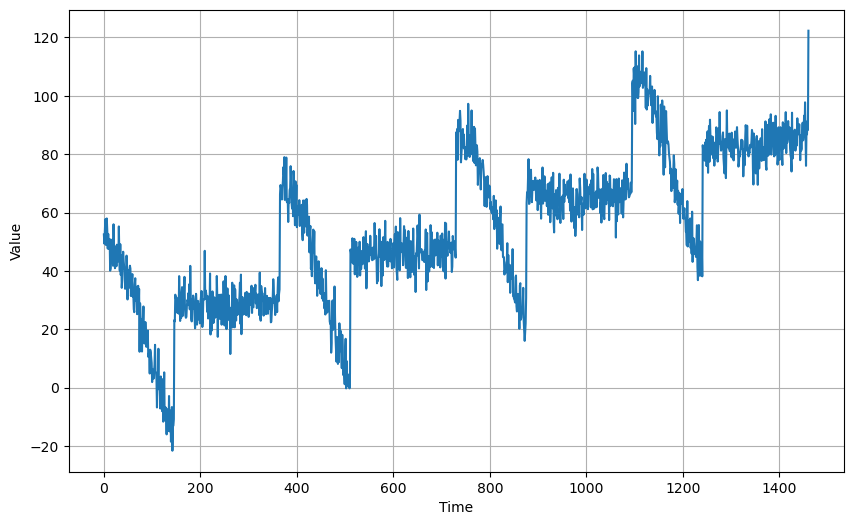

In [39]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [40]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [41]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


As mentioned in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), `SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the `input_shape`, you can specify `None` (like in the lecture video) if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to `window_size` as shown below if you want to set the `timesteps` dimension to the expected size of your data windows.

Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use another `Lambda()` layer to scale the output by 100 before it adjusts the layer weights. Feel free to remove this layer later after this lab and see what results you get.

In [42]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [43]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 3s 36ms/step - loss: 74.4317 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 35ms/step - loss: 70.2882 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 35ms/step - loss: 65.3998 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 35ms/step - loss: 60.0783 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 2s 56ms/step - loss: 54.3481 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 2s 53ms/step - loss: 48.1695 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 38ms/step - loss: 41.5046 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 38ms/step - loss: 34.3023 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 32ms/step - loss: 26.6733 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 2s 52ms/step - loss: 19.8331 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 50.0)

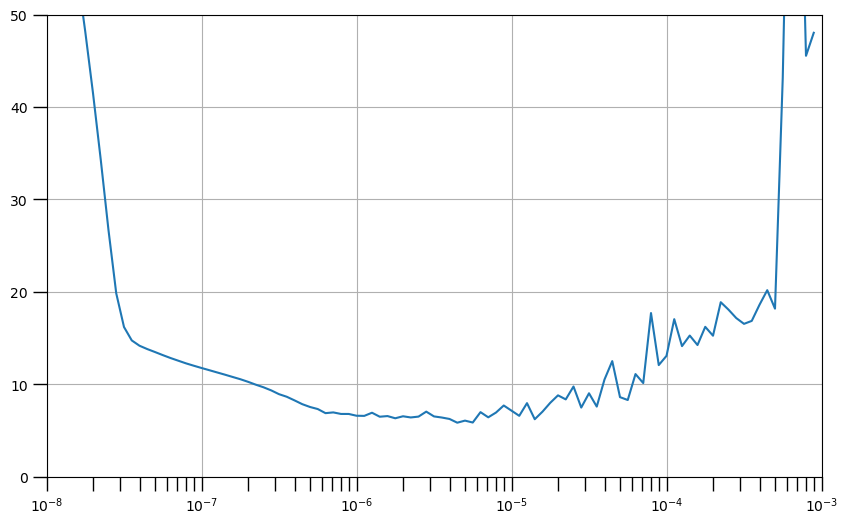

In [44]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [45]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 3s 35ms/step - loss: 33.1786 - mae: 33.6748
Epoch 2/100
31/31 [==============================] - 1s 34ms/step - loss: 15.2820 - mae: 15.7733
Epoch 3/100
31/31 [==============================] - 1s 32ms/step - loss: 11.3466 - mae: 11.8350
Epoch 4/100
31/31 [==============================] - 1s 29ms/step - loss: 9.0372 - mae: 9.5209
Epoch 5/100
31/31 [==============================] - 1s 26ms/step - loss: 7.7812 - mae: 8.2617
Epoch 6/100
31/31 [==============================] - 1s 33ms/step - loss: 7.1410 - mae: 7.6223
Epoch 7/100
31/31 [==============================] - 2s 43ms/step - loss: 6.7585 - mae: 7.2416
Epoch 8/100
31/31 [==============================] - 2s 45ms/step - loss: 6.4776 - mae: 6.9605
Epoch 9/100
31/31 [==============================] - 1s 36ms/step - loss: 6.3566 - mae: 6.8371
Epoch 10/100
31/31 [==============================] - 1s 36ms/step - loss: 6.2068 - mae: 6.6877
Epoch 11/100
31/31 [=======================

1/1 [==============================] - 0s 62ms/step


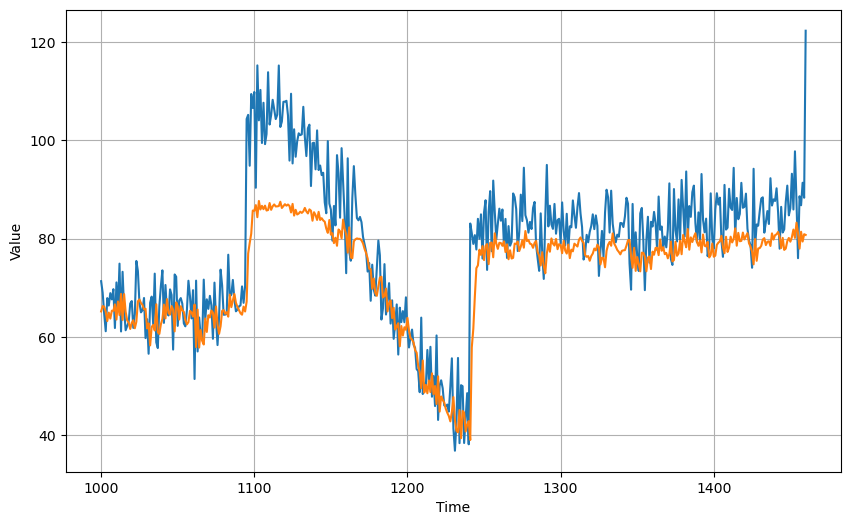

In [46]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [47]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

90.78448
7.062604


## LSTM

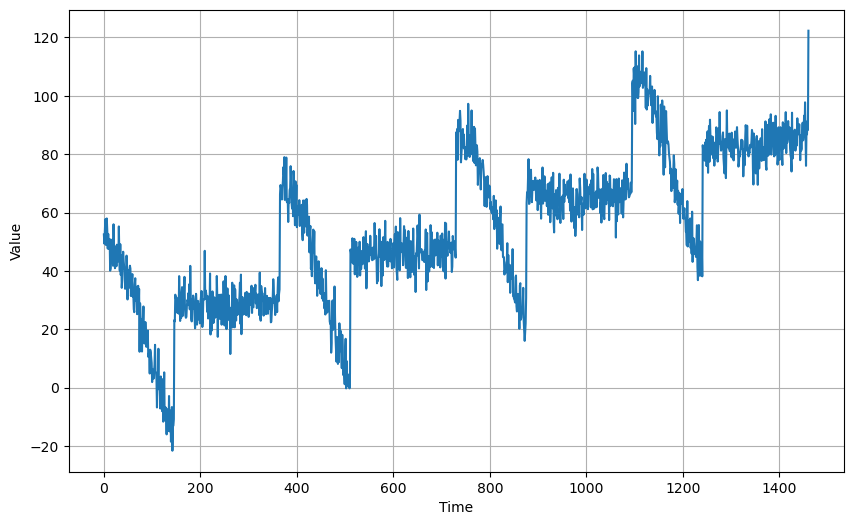

In [48]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [49]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

As mentioned, you will swap `SimpleRNN` for `LSTM` in this lab. It is also set as bidirectional below but feel free to revise later and see what results you get. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and you'll see that when you print the model summary below.

In [50]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

In [52]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 10s 131ms/step - loss: 18.2458 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 4s 125ms/step - loss: 18.1501 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 3s 109ms/step - loss: 18.0347 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 3s 110ms/step - loss: 17.9044 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 6s 175ms/step - loss: 17.7598 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 6s 184ms/step - loss: 17.5978 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 5s 160ms/step - loss: 17.4179 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 7s 220ms/step - loss: 17.2162 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 6s 200ms/step - loss: 16.9925 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 6s 179ms/step - loss: 16.7440 - lr: 2.8184e-0

(1e-08, 0.001, 0.0, 30.0)

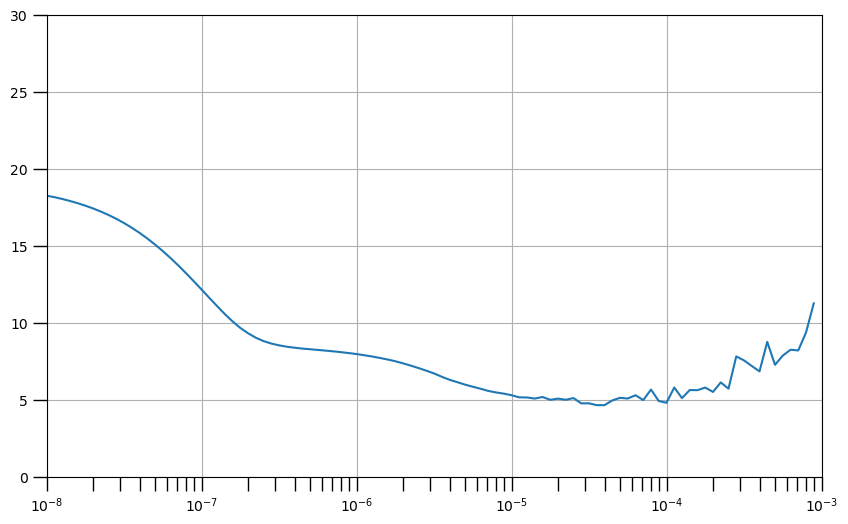

In [53]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

## Train the Model

You can then proceed to train the model with your chosen learning rate. 

*Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) method to declutter memory used by Keras. This is added in the first line below.*


Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

- Some of the problems are clearly visualize when we plot the loss against the MAE, there's a lot of noise and instability in there. One common cause for small spikes like that is a small batch size introducing further random noise.

In [54]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 13s 181ms/step - loss: 16.3741 - mae: 16.8685
Epoch 2/100
31/31 [==============================] - 6s 192ms/step - loss: 10.6167 - mae: 11.1053
Epoch 3/100
31/31 [==============================] - 6s 197ms/step - loss: 8.7029 - mae: 9.1839
Epoch 4/100
31/31 [==============================] - 7s 216ms/step - loss: 7.7794 - mae: 8.2626
Epoch 5/100
31/31 [==============================] - 5s 146ms/step - loss: 7.2678 - mae: 7.7540
Epoch 6/100
31/31 [==============================] - 5s 169ms/step - loss: 7.0063 - mae: 7.4883
Epoch 7/100
31/31 [==============================] - 5s 169ms/step - loss: 6.8401 - mae: 7.3268
Epoch 8/100
31/31 [==============================] - 6s 184ms/step - loss: 6.6782 - mae: 7.1610
Epoch 9/100
31/31 [==============================] - 5s 156ms/step - loss: 6.4881 - mae: 6.9696
Epoch 10/100
31/31 [==============================] - 5s 153ms/step - loss: 6.4829 - mae: 6.9658
Epoch 11/100
31/31 [==============

In [55]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

15/15 [==============================] - 4s 97ms/step


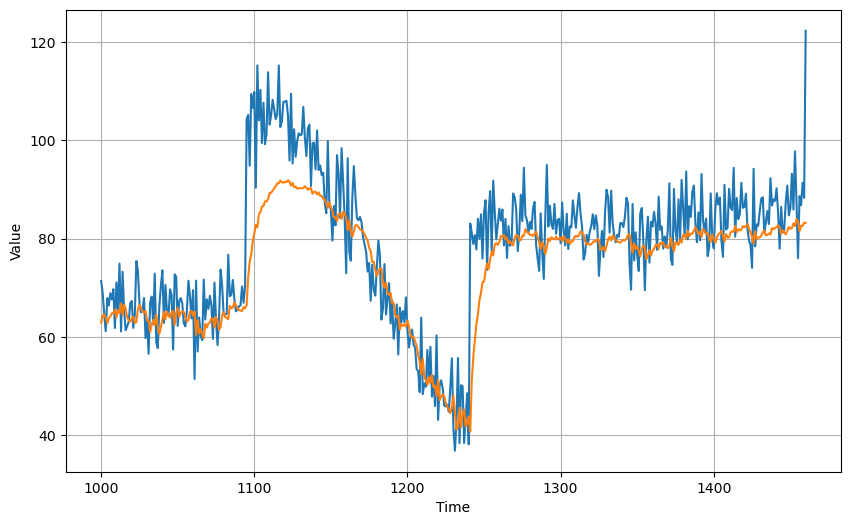

In [56]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [57]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

77.46985
6.29076


## Prepare Features and Labels

As mentioned in the lectures, you can experiment with different batch sizing here and see how it affects your results.

In [58]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [59]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Get initial weights
init_weights = model.get_weights()

In [61]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
62/62 [==============================] - 12s 116ms/step - loss: 171.1630 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 6s 93ms/step - loss: 98.7235 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 9s 145ms/step - loss: 28.6716 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 10s 159ms/step - loss: 11.4317 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 9s 143ms/step - loss: 10.5466 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 11s 171ms/step - loss: 10.1758 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 10s 161ms/step - loss: 9.9960 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 9s 148ms/step - loss: 9.8395 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 7s 111ms/step - loss: 9.6755 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 7s 116ms/step - loss: 9.5629 - lr: 2.8184e-08

(1e-08, 0.001, 0.0, 50.0)

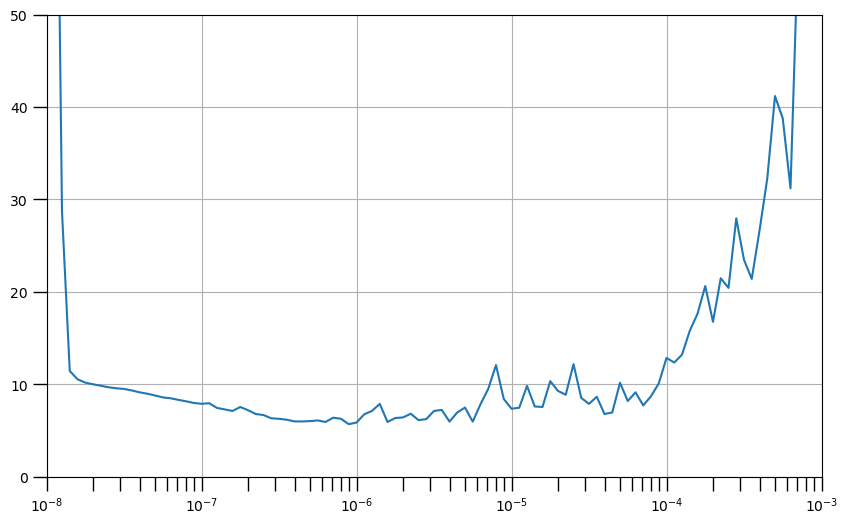

In [62]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [63]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
62/62 [==============================] - 27s 248ms/step - loss: 61.8767 - mae: 62.3710
Epoch 2/100
62/62 [==============================] - 13s 207ms/step - loss: 10.4662 - mae: 10.9548
Epoch 3/100
62/62 [==============================] - 17s 283ms/step - loss: 9.9588 - mae: 10.4446
Epoch 4/100
62/62 [==============================] - 15s 245ms/step - loss: 9.5648 - mae: 10.0512
Epoch 5/100
62/62 [==============================] - 16s 250ms/step - loss: 9.3462 - mae: 9.8302
Epoch 6/100
62/62 [==============================] - 14s 217ms/step - loss: 9.0821 - mae: 9.5705
Epoch 7/100
62/62 [==============================] - 15s 239ms/step - loss: 8.8674 - mae: 9.3533
Epoch 8/100
62/62 [==============================] - 18s 290ms/step - loss: 8.5559 - mae: 9.0425
Epoch 9/100
62/62 [==============================] - 16s 255ms/step - loss: 8.4018 - mae: 8.8870
Epoch 10/100
62/62 [==============================] - 16s 248ms/step - loss: 8.2042 - mae: 8.6927
Epoch 11/100
62/62 [===

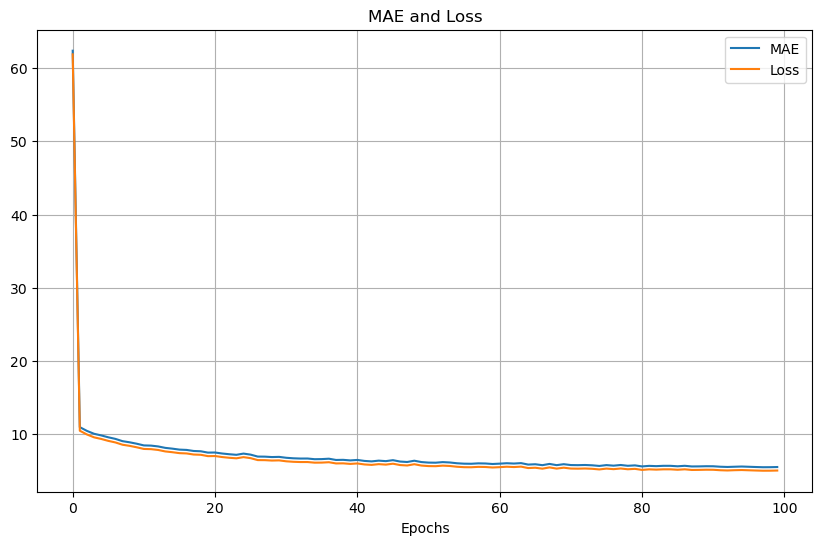

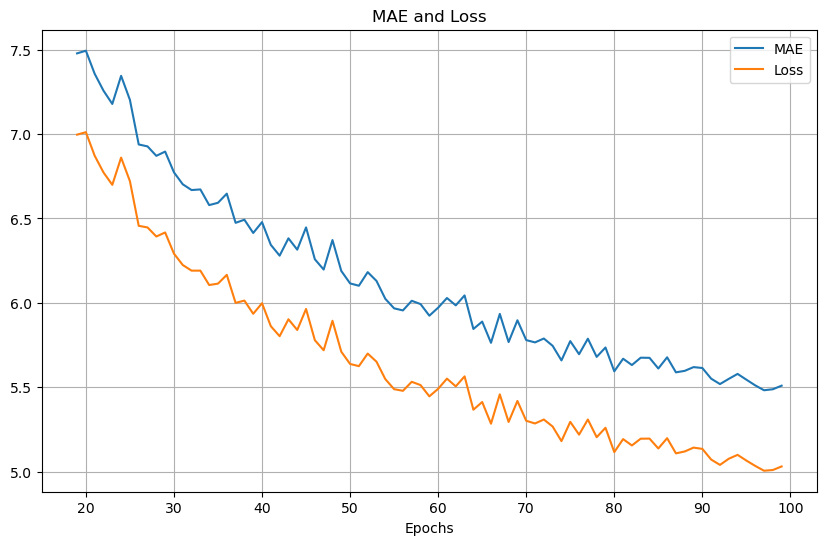

In [65]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

In [66]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

29/29 [==============================] - 4s 86ms/step


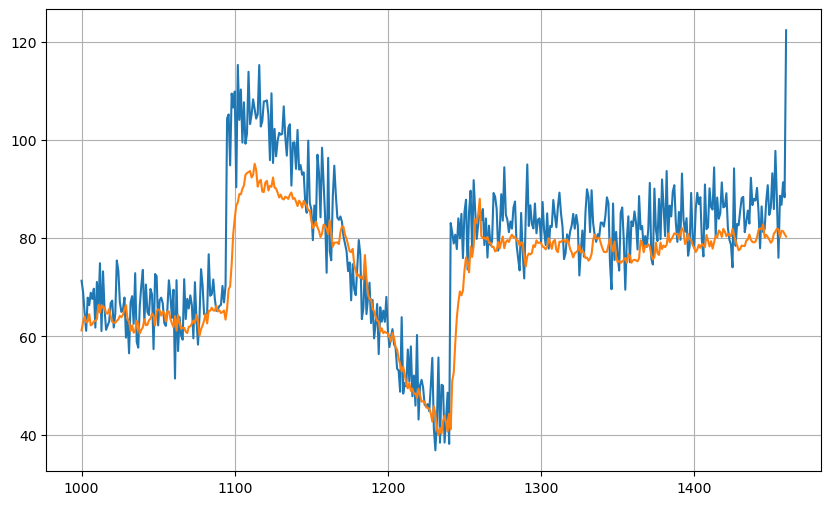

In [67]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [68]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

83.18617
6.714143


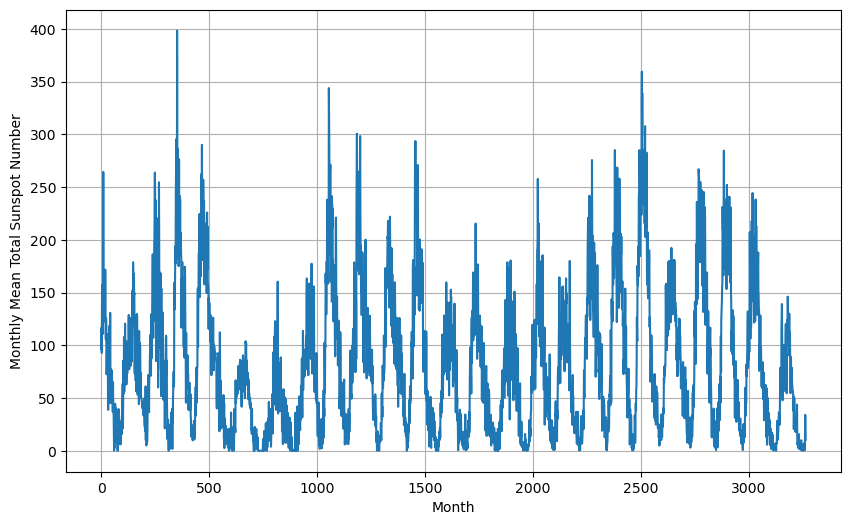

In [4]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()



# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

In [5]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid



In [8]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [9]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 2s 15ms/step - loss: 125.0284 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 2s 15ms/step - loss: 123.3935 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 2s 17ms/step - loss: 121.5314 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 2s 15ms/step - loss: 119.4217 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 2s 16ms/step - loss: 117.0279 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 11ms/step - loss: 114.3169 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 13ms/step - loss: 111.2404 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 2s 15ms/step - loss: 107.7414 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 12ms/step - loss: 103.7563 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 2s 15ms/step - loss: 99.2130 - lr: 2.8184e-08


(1e-08, 0.001, 0.0, 100.0)

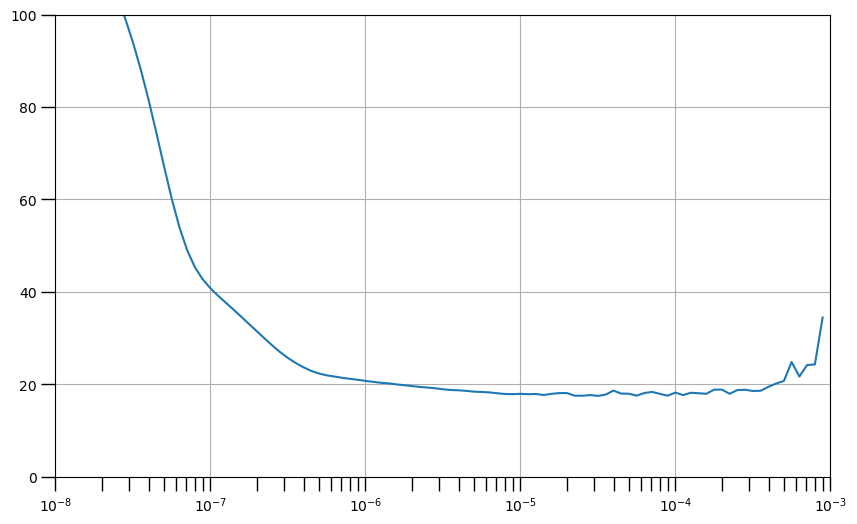

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [14]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [15]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 2s 14ms/step - loss: 26.8270 - mae: 27.3221
Epoch 2/100
93/93 [==============================] - 1s 12ms/step - loss: 20.3651 - mae: 20.8579
Epoch 3/100
93/93 [==============================] - 2s 14ms/step - loss: 19.5882 - mae: 20.0800
Epoch 4/100
93/93 [==============================] - 2s 14ms/step - loss: 19.3567 - mae: 19.8484
Epoch 5/100
93/93 [==============================] - 2s 16ms/step - loss: 18.6201 - mae: 19.1128
Epoch 6/100
93/93 [==============================] - 1s 11ms/step - loss: 18.4213 - mae: 18.9130
Epoch 7/100
93/93 [==============================] - 1s 10ms/step - loss: 18.4869 - mae: 18.9784
Epoch 8/100
93/93 [==============================] - 1s 13ms/step - loss: 18.4837 - mae: 18.9761
Epoch 9/100
93/93 [==============================] - 1s 14ms/step - loss: 18.1421 - mae: 18.6324
Epoch 10/100
93/93 [==============================] - 1s 12ms/step - loss: 17.7815 - mae: 18.2746
Epoch 11/100
93/93 [=========

9/9 [==============================] - 0s 13ms/step


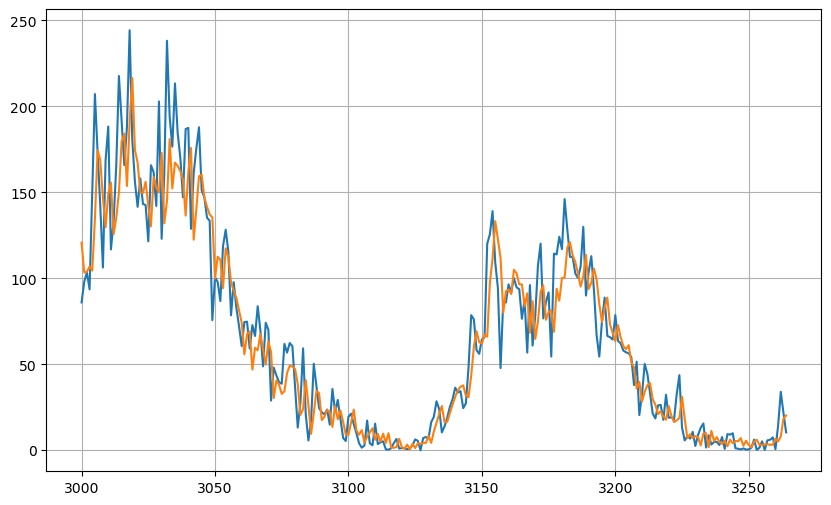

In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast


# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [17]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

13.928521


In [18]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                

In [20]:
# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 21s 162ms/step - loss: 47.4344 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 17s 182ms/step - loss: 37.7379 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 19s 206ms/step - loss: 33.1839 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 21s 223ms/step - loss: 30.7396 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 14s 145ms/step - loss: 29.1702 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 17s 183ms/step - loss: 27.7245 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 17s 179ms/step - loss: 26.4237 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 15s 163ms/step - loss: 25.4678 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 19s 207ms/step - loss: 24.7042 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 14s 152ms/step - loss: 24.0812 - lr: 

(1e-08, 0.001, 0.0, 100.0)

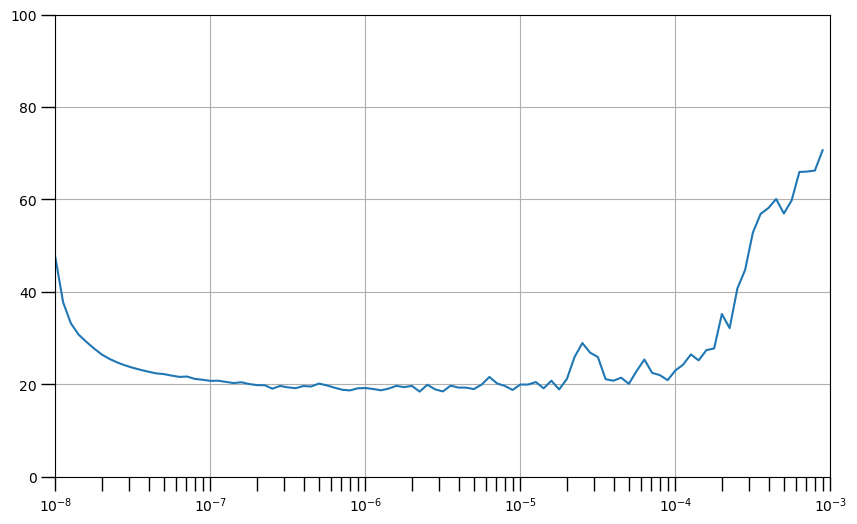

In [21]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [22]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [23]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [24]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 27s 170ms/step - loss: 28.2221 - mae: 28.7180
Epoch 2/100
93/93 [==============================] - 26s 276ms/step - loss: 23.0697 - mae: 23.5635
Epoch 3/100
93/93 [==============================] - 33s 347ms/step - loss: 20.7825 - mae: 21.2756
Epoch 4/100
93/93 [==============================] - 34s 355ms/step - loss: 19.8444 - mae: 20.3364
Epoch 5/100
93/93 [==============================] - 44s 464ms/step - loss: 19.7549 - mae: 20.2489
Epoch 6/100
93/93 [==============================] - 27s 289ms/step - loss: 19.3834 - mae: 19.8762
Epoch 7/100
93/93 [==============================] - 39s 423ms/step - loss: 18.8683 - mae: 19.3609
Epoch 8/100
93/93 [==============================] - 44s 459ms/step - loss: 18.9045 - mae: 19.3983
Epoch 9/100
93/93 [==============================] - 44s 457ms/step - loss: 19.2912 - mae: 19.7841
Epoch 10/100
93/93 [==============================] - 39s 405ms/step - loss: 18.9923 - mae: 19.4850
Epoch 11/

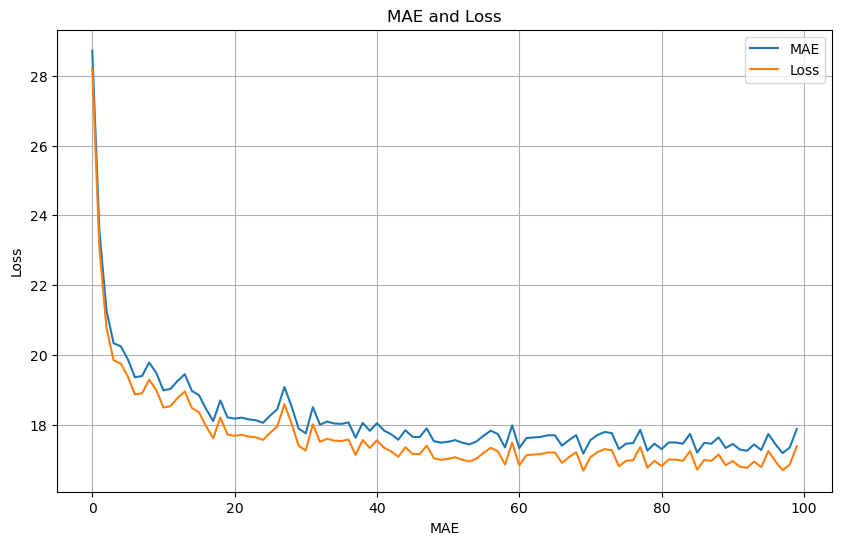

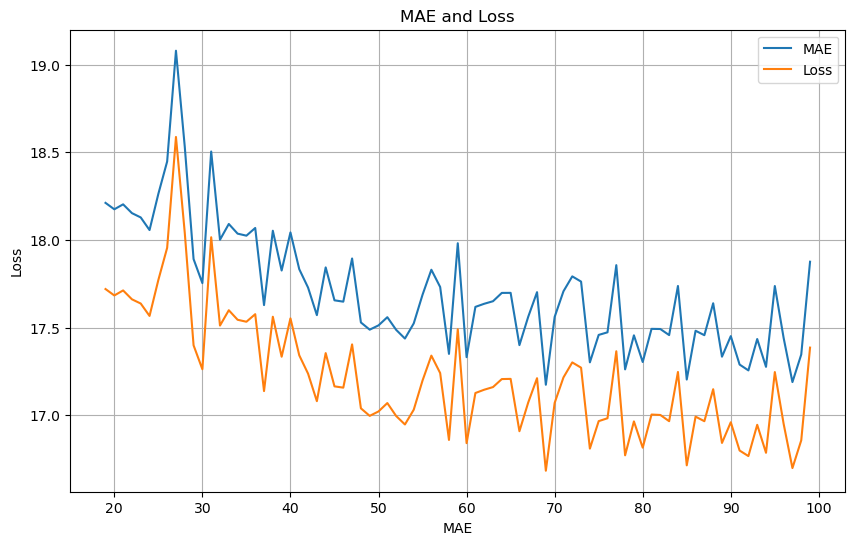

In [25]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

9/9 [==============================] - 5s 154ms/step


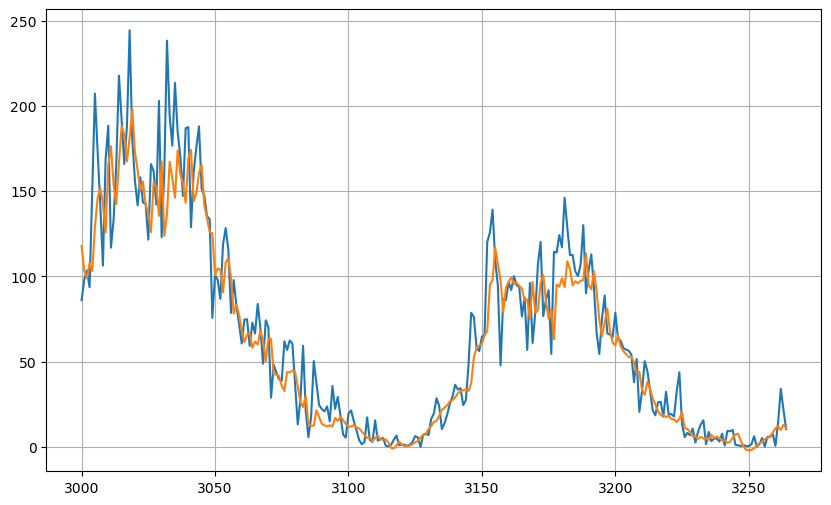

In [26]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [27]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

13.238236
